In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
import pandas as pd

In [2]:
# trajectory 
#trajectory = "./biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn_Cterm_apo.all.dcd"
#pdb = "./biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn.cterm.mae2pdb.pdb"
trajectory = "./biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn_no_ions.dcd"
pdb= "./biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn_no_ions.pdb"
outdir='./outdir'
if not os.path.exists('outdir'):
    os.makedirs('outdir')

In [ ]:
# table, bonds = md.load(pdb_test).topology.to_dataframe()
# arr = table.to_numpy()
# first = np.concatenate([arr[:12], arr[-2:]])
# first[-2:,0] = np.array([12,13])
# second = arr[12:-2]
# second[:,0] = np.arange(14, len(second)+14)
# tot = np.concatenate([first,second])
# top = pd.DataFrame(tot, columns = table.columns)

In [3]:
# table, bonds = md.load(pdb).topology.to_dataframe()
# arr = table.to_numpy()
# first = np.concatenate([arr[:12], arr[-2:]])
# first[-2:,0] = np.array([12,13])
# second = arr[12:-2]
# second[:,0] = np.arange(14, len(second)+14)
# tot = np.concatenate([first,second])
# top = pd.DataFrame(tot, columns = table.columns);top = md.Topology.from_dataframe(top,bonds)
table, bonds = md.load(pdb).topology.to_dataframe()
arr = table.to_numpy()
rearrange = np.concatenate([arr[-2:], arr[:-2]])
rearrange[:,0] = np.arange(294)
top = pd.DataFrame(rearrange, columns = table.columns)
top = md.Topology.from_dataframe(top,bonds)
trj = md.load(trajectory, top=top)

In [4]:
# could come back to get the dihedral indices later  
def gen_CA(CAatoms):
    """
    Generate an array of alpha carbons  
    input: CAatoms 
    output: numpy array of CA labels 
    """
    
    CAlabel=[]
    #CAdihe_index=[]
    #CAang_index=[]
    #CAvec_index=[]    
    for i in range(0,len(CAatoms)):
        CAlabel.append(trj.topology.atom(CAatoms[i]).residue.resSeq)
    CAlabel =np.array(CAlabel).astype(int)

    return CAlabel

def writhe_matrix(s1,s2):
    v13 = s2[:,0] - s1[:,0]
    v23 = s2[:,0] - s1[:,1]
    v24 = s2[:,1] - s1[:,1]
    v14 = s2[:,1] - s1[:,0]
    v = [v13,v23,v24,v14,v13,v23]
    e = []
    l13 = np.linalg.norm(v13,axis=1)
    l23 = np.linalg.norm(v23,axis=1)
    l24 = np.linalg.norm(v24,axis=1)
    l14 = np.linalg.norm(v14,axis=1)
    ls = [l13,l23,l24,l14]   
    for l in ls:
        if np.sum(l) == 0.0:
            return 0
    e13 = v13/l13[:,None]
    e23 = v23/l23[:,None]
    e24 = v24/l24[:,None]
    e14 = v14/l14[:,None]
    e = [e13,e23,e24,e14,e13,e23] 
        #compute the angles
    s = 0
    for i in range(1,len(e)-1):
        a = np.asarray(e[i-1])
        b = np.asarray(e[i])
        c = np.asarray(e[i+1])
        #a =e[i-1]
        #b =e[i]
        #c = e[i+1]
        v1=a-b
        v3=c-b
        #a=np.dot(v1,v3)
        a=(v1*v3).sum(axis=1)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        #a=np.dot(v1,v3)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
    w = np.sign(s)*2*np.pi - s
    return w

def wr_tot(CAlabel, CApos): # pass in model_input 
    """
    computes the top half of the total writhe matrix with values of dimension n_frames
    input: CAlabel, CApos
    returns: dictionary of dictionary, where each key indicates segment pair
    """
    dim = int((len(CAlabel) - 2)*(len(CAlabel) - 3)/2)
    model_input = np.empty((dim, trj.n_frames))
    wr_total = {}
    #wr_total = np.zeros((len(CAlabel)-1,len(CAlabel)-1, trj.n_frames))
    
    count = 0
    for j in range(0,len(CAlabel)-1):
        wr_total[j]={}
        v1=CApos[:,j]; v2=CApos[:,j+1];
        s1=np.empty((len(CApos),2,3))
        s1[:,0]=v1
        s1[:,1]=v2
        
        for k in range(j+1,len(CAlabel)-1):
            v3=CApos[:,k]; v4=CApos[:,k+1];
            s2=np.empty((len(CApos),2,3))
            s2[:,0]=v3
            s2[:,1]=v4
            wr_total[j][k]= writhe_matrix(s1,s2) 
            
            if k > j+1: 
                #if k == j+2 and j == 0: # just because of empty, go back and optimize
                    #w = writhe_matrix(s1,s2)
                    #model_input = wr_total[j][k].reshape(trj.n_frames, 1) # define 
                model_input[count] = wr_total[j][k]
                count += 1 

    model_input = np.transpose(model_input)
    return wr_total, model_input 

def writhe_by_res(wr_total, CApos):
    """
    computes the writhe by residue, total contribution for each frame
    ouput: dictionary, writhe by residue 
    """
    
    #writhe_by_res={}
    writhe_by_res=np.empty((len(wr_total), len(CApos[:,0])))
    wtot=np.zeros(len(CApos[:,0]))
    print("this is the shape of wtot,", wtot.shape)
    
    for i in wr_total:
        w=np.zeros(len(CApos[:,0]))
        for j in wr_total[i]:
            w+=wr_total[i][j] 
        writhe_by_res[i]=w
        wtot+=w
    return writhe_by_res

def writhe_avg(wr_total, CAlabel): 
    """
    computes the writhe average 
    output: numpy array of averages 
    """
    writhe_matrx= np.zeros((len(CAlabel)-1,len(CAlabel)-1))
    for j in wr_total:
        for k in wr_total[j]:
            writhe_matrx[j,k]= np.average(wr_total[j][k])
            writhe_matrx[k,j]= writhe_matrx[j,k]
    return writhe_matrx

In [5]:
def W_ij(trj):
    """
    compute writhe 
    returns: total writhe, writhe by residue, average writhe matrix, and the writhe input 
    """
    CAatoms= trj.topology.select('name CA')
    CApos= trj.xyz[:,CAatoms]
    CAlabel= gen_CA(CAatoms)
    #n = len(CAlabel)-1
    #dim = (n-1)(n-2)/2
    #model_input = np.empty((1,trj.n_frames))
    wr_total, model_in= wr_tot(CAlabel, CApos)
    wr_by_res= writhe_by_res(wr_total, CApos)
    writhe_matrx= writhe_avg(wr_total, CAlabel)
    return wr_total, wr_by_res, writhe_matrx, model_in

In [6]:
wr_total, wr_by_res, writhe_matrx, w_model_in = W_ij(trj)

this is the shape of wtot, (555446,)


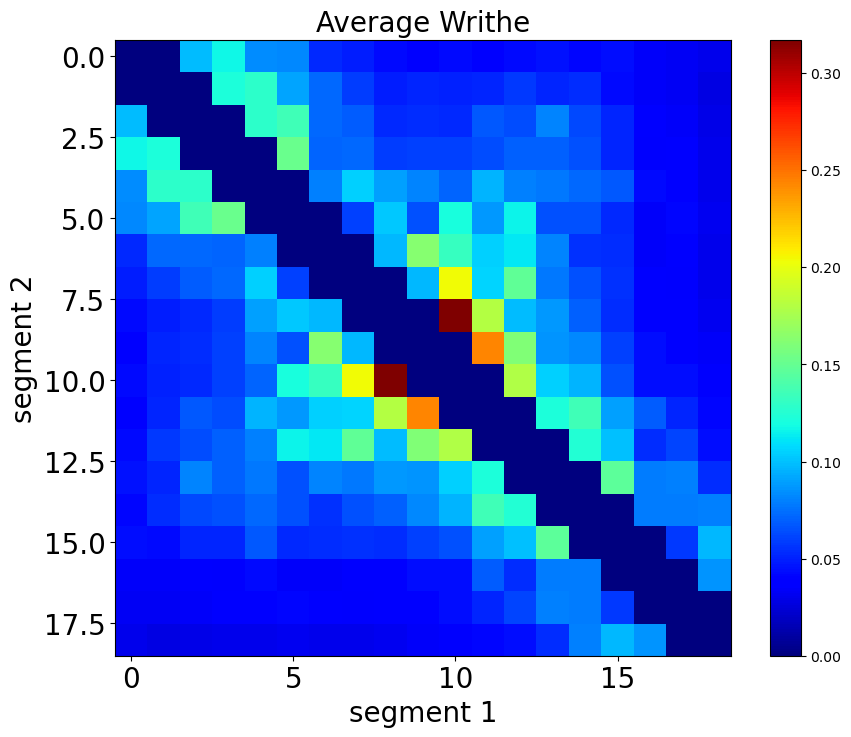

In [7]:
# plot the average writhe matrix 
#%matplotlib notebook
fig = plt.figure(figsize=(10, 8))
plt.imshow(writhe_matrx,cmap='jet')
plt.xlabel("segment 1", size = 20)
plt.xticks()
plt.ylabel("segment 2", size = 20)
plt.title("Average Writhe", size = 20)
plt.colorbar()
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("./outdir/average_writhe_asyn.png", dpi=200)

Text(0.5, 0, 'Time [$\\mu$s]')

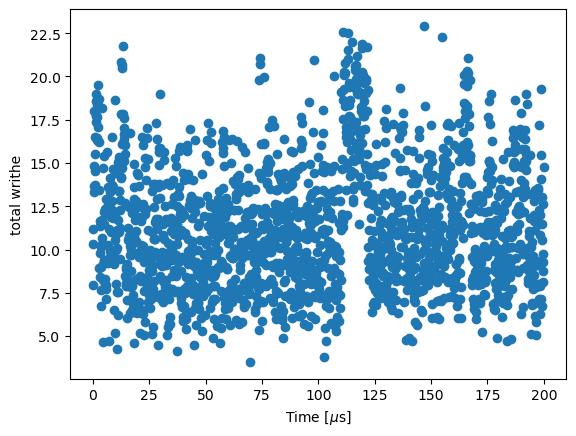

In [144]:
# how to get the total writhe as a function of time 
time=np.linspace(0,200,trj.n_frames)
plt.scatter(time[:-1:300], summation[:-1:300], marker="o")
plt.ylabel("total writhe")
plt.xlabel("Time [$\mu$s]")

In [140]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
sequence

[ASP121,
 ASN122,
 GLU123,
 ALA124,
 TYR125,
 GLU126,
 MET127,
 PRO128,
 SER129,
 GLU130,
 GLU131,
 GLY132,
 TYR133,
 GLN134,
 ASP135,
 TYR136,
 GLU137,
 PRO138,
 GLU139,
 ALA140]

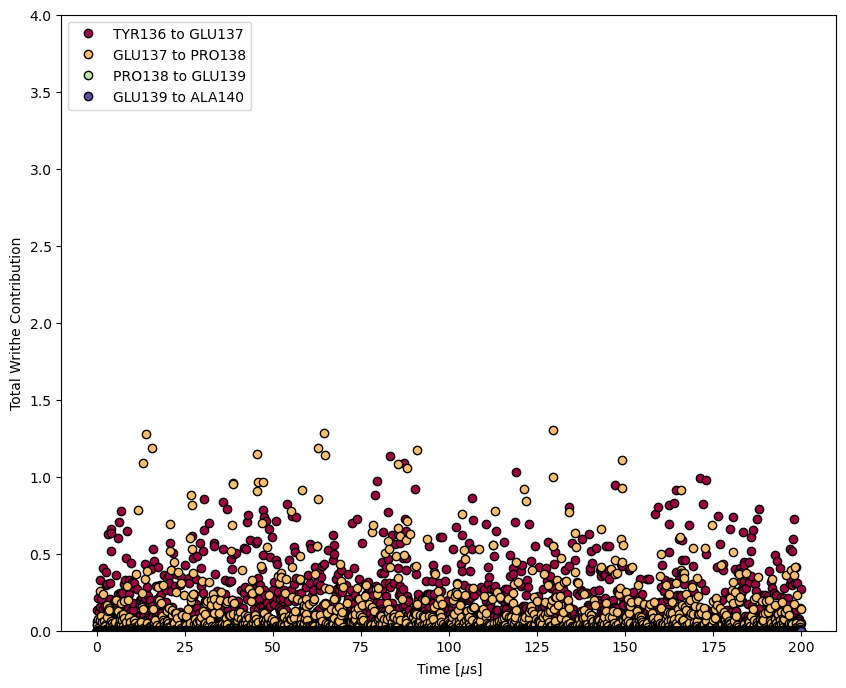

In [164]:
#num_seg = np.arange(wr_by_res.shape[0])
#num_seg= np.arange(0,5)
stride = 300
# num_seg=np.arange(5,10)
# num_seg=np.arange(10,15)
num_seg=np.arange(15,19)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(num_seg))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(num_seg, colors):
    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        time[:-1:stride],
        wr_by_res[k][:-1:stride],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
        label= str(sequence[k]) + " to " + str(sequence[k+1])
    )

plt.ylabel("Total Writhe Contribution")
plt.xlabel("Time [$\mu$s]")
plt.ylim((0,4))
plt.legend(loc = "upper left")

In [ ]:
from pca_plots import *
plt_avg_matrx(writhe_matrx, title="Writhe, Average", count=0)
plt.title("Average Writhe, asyn", size = 20)
#plt.savefig("./outdir/average_writhe_asyn.png", dpi=200)

Carry out PCA and analyze where the variance is coming from 

In [21]:
# PCA on writhe 
wmodel = PCA(n_components=2)
reduced_writhe = wmodel.fit_transform(w_model_in) 
WPC1=reduced_writhe[:, 0]
WPC2=reduced_writhe[:,1]

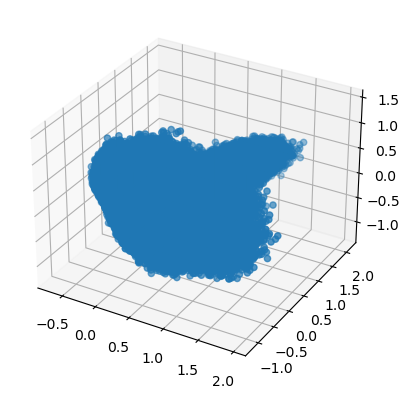

In [17]:
# from mpl_toolkits.mplot3d import Axes3D
# wmodel = PCA(n_components=3)
# reduced_writhe = wmodel.fit_transform(w_model_in) 

# WPC1=reduced_writhe[:, 0][::500]
# WPC2=reduced_writhe[:,1]
# WPC3=reduced_writhe[:,2]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs=WPC1, ys=WPC2, zs=WPC3)

# ax.set_xlabel('PC1 Label')
# ax.set_ylabel('PC2 Label')
# ax.set_zlabel('PC3 Label')
# plt.colorbar()

In [37]:
print("This is the explained variance of the data from the two components", np.sum(wmodel.explained_variance_ratio_)*100)

This is the explained variance of the data from the two components 15.058212528477878


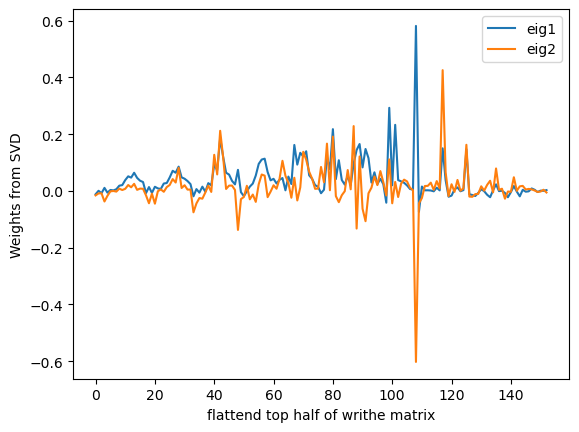

In [34]:
plt.plot(wmodel.components_[0,:], label="eig1")
plt.plot(wmodel.components_[1,:], label="eig2")
plt.xlabel("flattend top half of writhe matrix")
plt.ylabel("Weights from SVD")
plt.legend()

In [99]:
def reconstruct_matrx(pca, n_components=2, num_res=20): 
    reconstructed_matrices = np.empty((num_res-1,num_res-1,n_components))
    
    rev = np.flip(np.arange(1, num_res-2))
    for n in range(n_components): 
        # grab eigenvalue 
        eigh = pca.components_[n,:]
        matrx = np.zeros((num_res-1,num_res-1))
        
        # reconstruct the matrix 
        count = 0 
        for k in range(2, num_res-1): # starts at 2 because of hack
            val = eigh[:rev[count]]
            eigh = eigh[rev[count]:]
            matrx[count][k:] = val
            #matrx[rev[count]+1][:rev[count]] = np.flip(val)
            count += 1 
        
        
        # do other side of matrix 
        for i in range(num_res-1): 
            for j in range(i+1, num_res-1):
                matrx[j][i] = matrx[i][j]
        
        reconstructed_matrices[:,:,n] = matrx
        
    return reconstructed_matrices

In [100]:
reconstructed_matrices = reconstruct_matrx(wmodel)
matrx_e1 = reconstructed_matrices[:,:,0]
matrx_e2 = reconstructed_matrices[:,:,1]

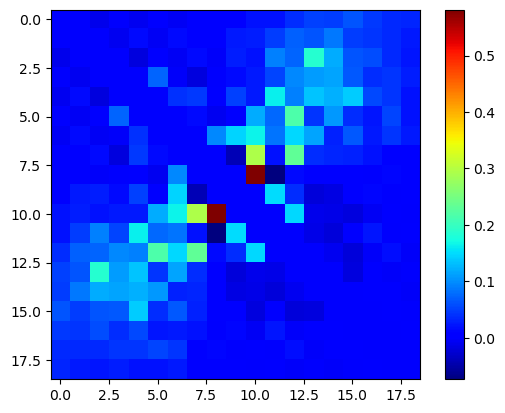

In [101]:
plt.imshow(matrx_e1, cmap="jet")
plt.colorbar()

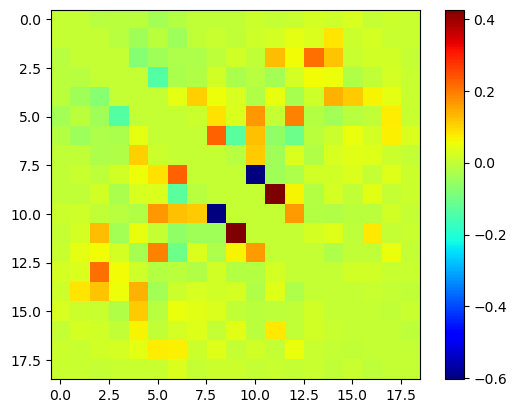

In [102]:
plt.imshow(matrx_e2, cmap="jet")
plt.colorbar()

In [532]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [103]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

seq=[]
for i in range(len(sequence)-1): 
    seq.append(str(sequence[i]) + "-"+ str(sequence[i+1]))

# get rid of some 
n=2
for i in range (0,len(seq)): 
    if (i % n !=0):
        seq[i]=''
        
print(len(seq))

19


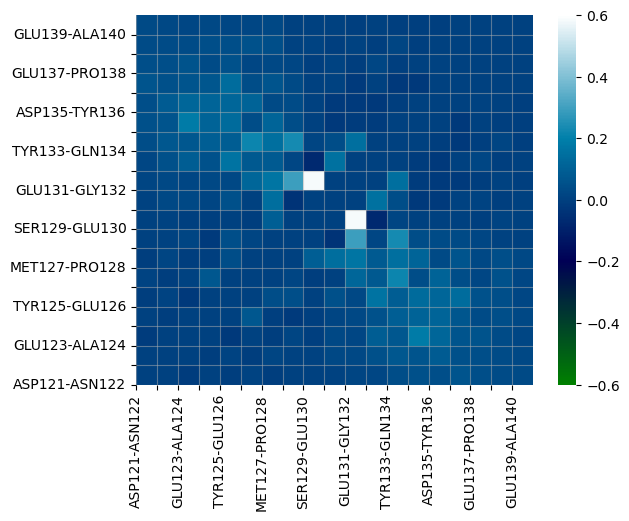

In [104]:
ax = sns.heatmap(matrx_e1, vmin=-0.6, vmax=0.6,cmap='ocean')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,19))
ax.set_yticks(range(0,19))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

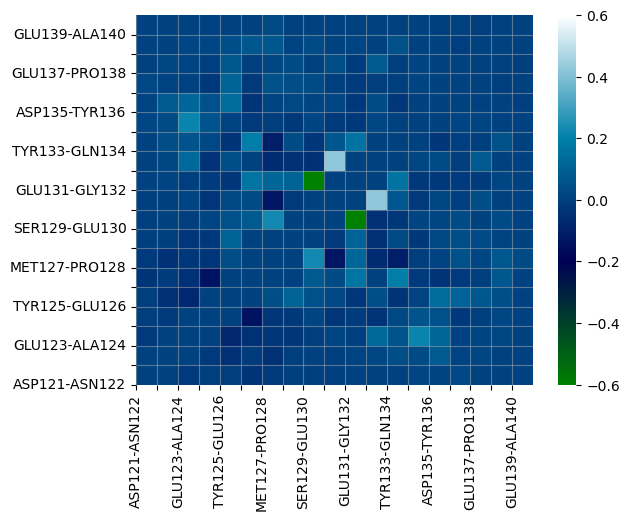

In [105]:
ax = sns.heatmap(matrx_e2, vmin=-0.6, vmax=0.6,cmap='ocean')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,19))
ax.set_yticks(range(0,19))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

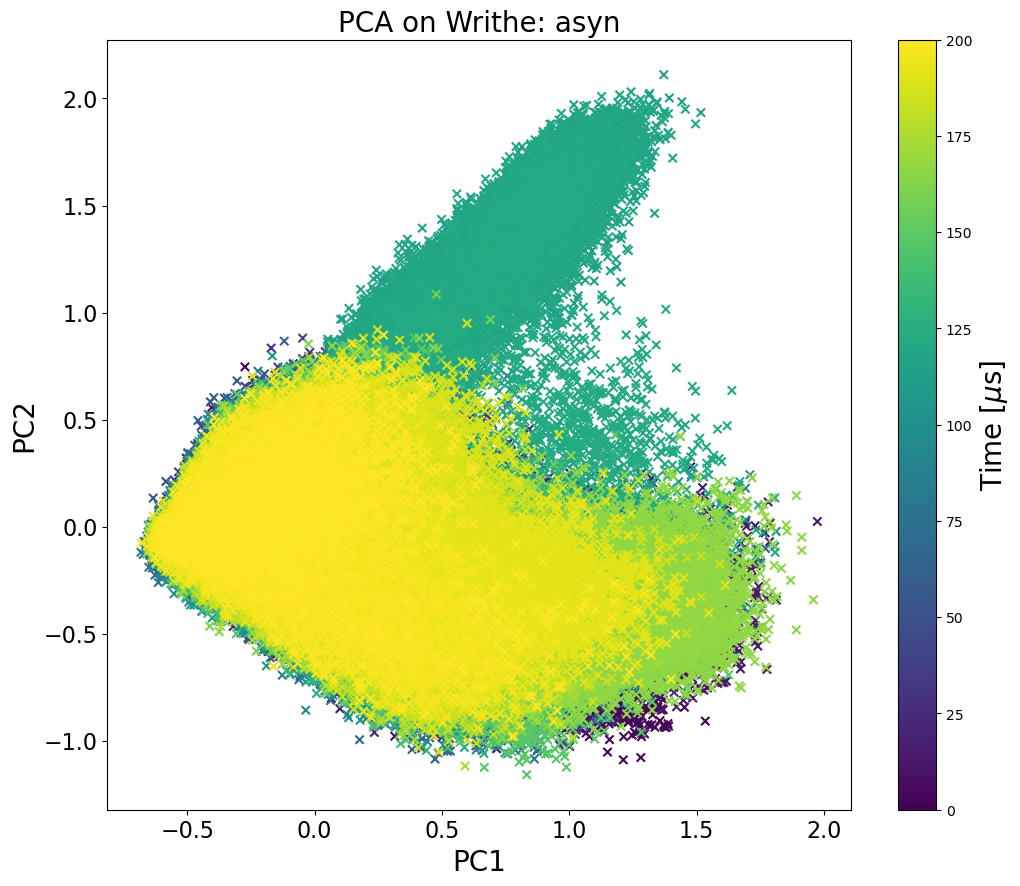

In [43]:
# Projecting time on principal components
time=np.linspace(0,200,trj.n_frames)
fig = plt.figure(figsize=(12, 10))
plt.scatter(WPC1, WPC2, marker='x', c=time)
plt.xlabel('PC1',size=20)
plt.ylabel('PC2',size=20) 
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('PCA on Writhe: asyn', size=20)
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]',size=20)
plt.savefig("./outdir/time_projected_writhe_asyn.png", dpi=250)

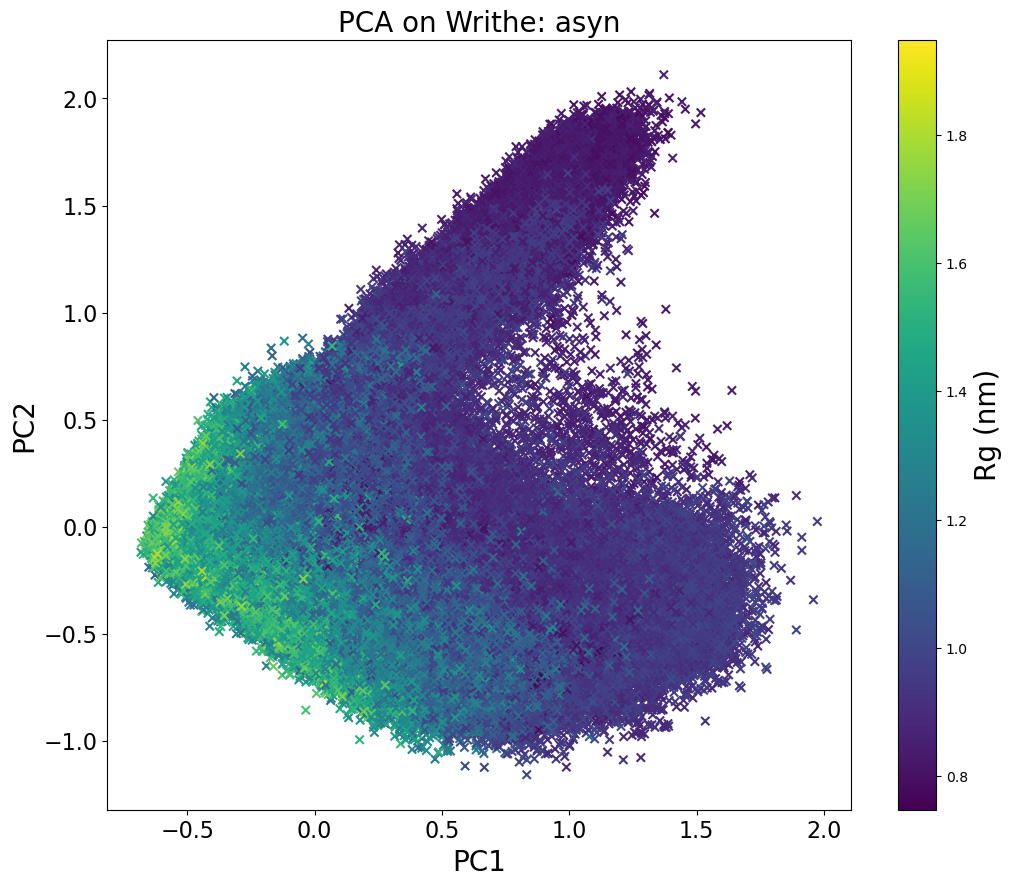

In [44]:
# Projecting radius of gyration on principal components 
rg=md.compute_rg(trj, masses=None)
fig = plt.figure(figsize=(12, 10))
plt.scatter(WPC1, WPC2, marker='x', c=rg)
plt.xlabel('PC1', size=20)
plt.xticks(size=16)
plt.ylabel('PC2', size=20) 
plt.yticks(size=16)
plt.title('PCA on Writhe: asyn', size=20)
cbar = plt.colorbar()
cbar.set_label('Rg (nm)', size=20)
plt.savefig("./outdir/Rg_projected_writhe_asyn.png", dpi=250)

In [45]:
from matplotlib import cm 

cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)

In [46]:
from sklearn.cluster import KMeans
concat = np.column_stack((WPC1, WPC2))
X = concat
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
scat = np.split(centers,2, axis=1)

In [47]:
centers

array([[ 0.68444645,  1.22216605],
       [-0.25024689,  0.02985366],
       [ 0.58051245, -0.37016465]])

In [ ]:
# #https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
# from sklearn import metrics
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import DBSCAN

# X = concat
# db = DBSCAN(eps=0.1, min_samples=5000).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Text(0.5, 1.0, 'Kmeans Clustering from Writhe')

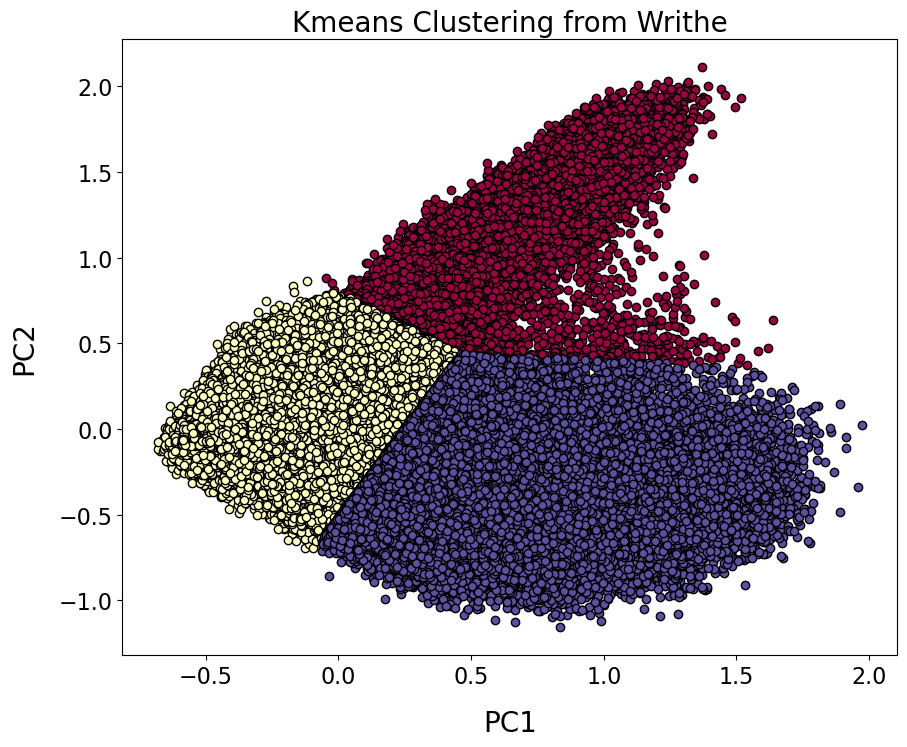

In [48]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Kmeans Clustering from Writhe", size = 20, loc="center")
#plt.savefig('./outdir/writhe_kmeans_clustering.png',dpi=200)

In [49]:
wbasin1 = np.where(labels == 0)[0]
wbasin2 = np.where(labels == 1)[0]
wbasin3 = np.where(labels == 2)[0]
# writhe_basin1_trj = trj.slice(wbasin1)
# writhe_basin1_trj.save_dcd("./outdir/kmeans_writhe_basin1_trj.dcd")
# writhe_basin1_trj = trj.slice(wbasin2)
# writhe_basin1_trj.save_dcd("./outdir/kmeans_writhe_basin2_trj.dcd")
# writhe_basin1_trj = trj.slice(wbasin3)
# writhe_basin1_trj.save_dcd("./outdir/kmeans_writhe_basin3_trj.dcd")

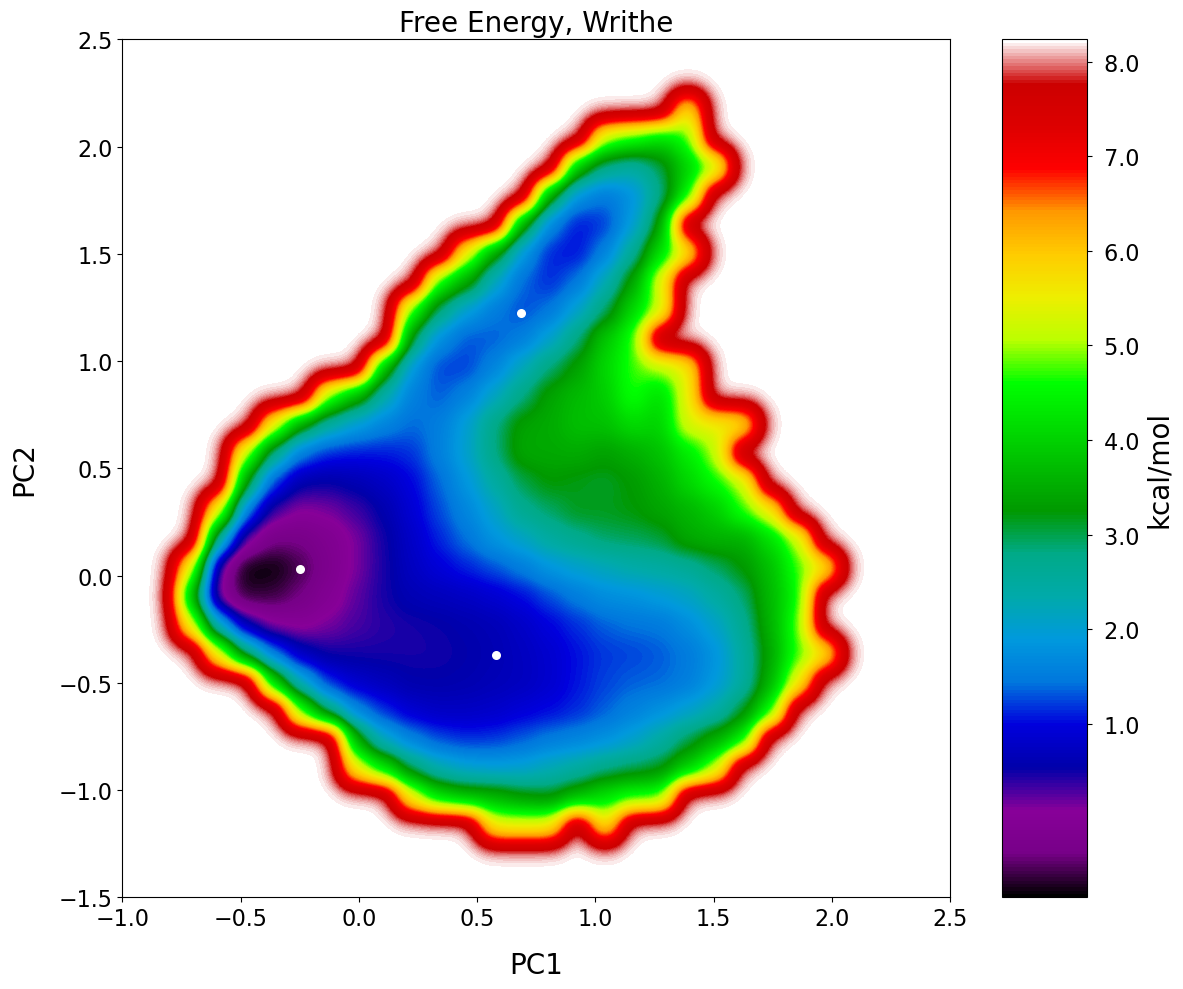

In [50]:
# free energy plot for writhe 
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


dG,xedges,yedges=free_energy(WPC2, WPC1, 300, -1.5, 2.5, -1, 2.5)

fig = plt.figure(figsize=(12, 10))
# set color 
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap=n_cmap, aspect='auto')
cbar_ticks = [i for i in range(1,9)]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
cb.set_label("kcal/mol", size=20) 

imaxes = plt.gca()
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.title("Free Energy, Writhe", size = 20, loc="center")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(scat[0], scat[1], c="white", marker = "o", s=30)
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='16')
plt.tight_layout()
#plt.savefig('./outdir/free_energy_projected_writhe_asyn.png',dpi=200)

In [171]:
# get centroids 
traj_basin = md.load("./outdir/kmeans_writhe_basin3_trj.dcd", top=pdb, stride=10)
atom_indices = [a.index for a in traj_basin.topology.atoms if a.element.symbol != 'H']
distances = np.empty((traj_basin.n_frames, traj_basin.n_frames))
for i in range(traj_basin.n_frames):
    distances[i] = md.rmsd(traj_basin, traj_basin, i, atom_indices=atom_indices)

beta = 1
index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
print(index)

centroid = traj_basin[index]
print(centroid)

901
<mdtraj.Trajectory with 1 frames, 294 atoms, 21 residues, and unitcells>


code is too slow, so only doing about 3,000 - 4,000 data points at a time
Basin 1: 172, stride 30 
Basin 2: 1349, stride 80 
Basin 3: 901, stride 10 

In [44]:
cen1 = centers 
cen2 = centers.copy()
centers = np.concatenate((cen1,cen2))
centers

array([[ 0.58088726, -0.37042176],
       [-0.25012784,  0.02977549],
       [ 0.68423506,  1.22168789],
       [ 0.58088726, -0.37042176],
       [-0.25012784,  0.02977549],
       [ 0.68423506,  1.22168789]])

In [47]:
# # testing out writing out the centers to file 
# with open(outdir+'/centers.txt', 'w') as f:
#     f.write("Writhe Centers \n")
#     for num, i in enumerate(cen1): 
#         f.write(str(num) + " " + str(i) + "\n")
    
#     f.write("Other Centers \n")
#     for num, i in enumerate(cen2): 
#         f.write(str(num) + " " + str(i) + "\n")
    
# f.close()

What about changing the length of the segment? 

In [51]:
# prime number of segments, will have to leave out the last atom in trajectory

def W_ij_eos(trj,stride=2):
    """
    compute writhe 
    returns: total writhe, writhe by residue, average writhe matrix, and the writhe input 
    """
    CAatoms= trj.topology.select('name CA')
    CApos= trj.xyz[:,CAatoms][:,::stride] # prime number so need to leave out last residue 
    CAlabel= gen_CA(CAatoms)[::stride] # prime number so need to leave out last residue
    
    wr_total, model_in= wr_tot(CAlabel, CApos)
    wr_by_res= writhe_by_res(wr_total, CApos)
    writhe_matrx= writhe_avg(wr_total, CAlabel)# hacky way of getting the matrix to look like i want while not changing writhe_avg
    return wr_total, wr_by_res, writhe_matrx, model_in

In [52]:
wr_total_eos, wr_by_res_eos, writhe_matrx_eos, w_model_in_eos = W_ij_eos(trj)

this is the shape of wtot, (555446,)


In [54]:
wmodel_eos = PCA(n_components=2)
wmodel_eos.fit(w_model_in_eos)

PCA(n_components=2)

In [55]:
reduced_writhe_eos = wmodel_eos.fit_transform(w_model_in_eos) 
WPC1_eos=reduced_writhe_eos[:, 0]
WPC2_eos=reduced_writhe_eos[:,1]

In [56]:
wmodel_eos.explained_variance_ratio_

array([0.23373662, 0.10600919])

In [57]:
from sklearn.cluster import KMeans
concat = np.column_stack((WPC1_eos, WPC2_eos))
X = concat
kmeans = KMeans(n_clusters=3).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
scat = np.split(centers,2, axis=1)

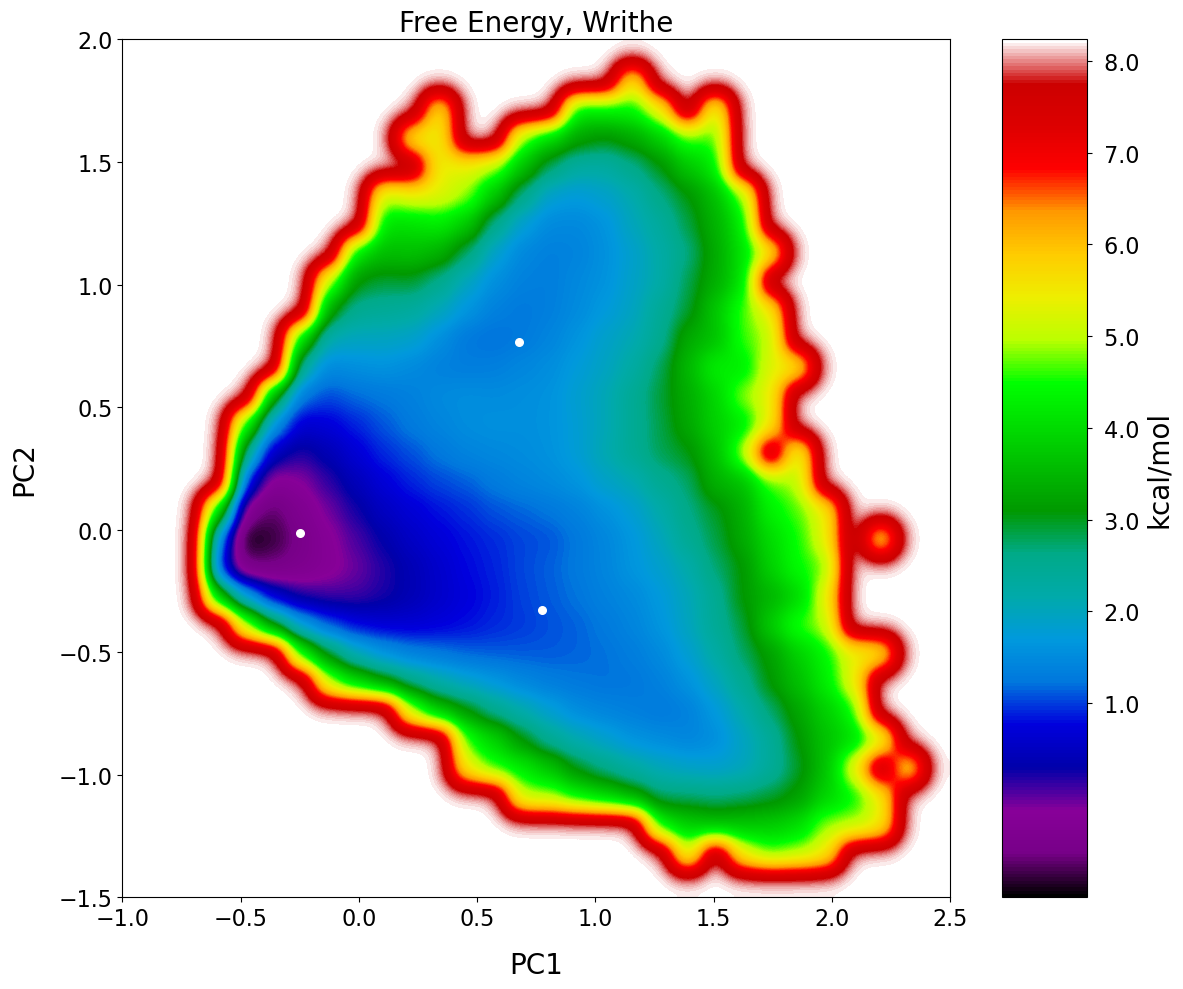

In [58]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


dG,xedges,yedges=free_energy(WPC2_eos, WPC1_eos, 300, -1.5, 2.0, -1, 2.5)

fig = plt.figure(figsize=(12, 10))
# set color 
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap=n_cmap, aspect='auto')
cbar_ticks = [i for i in range(1,9)]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
cb.set_label("kcal/mol", size=20) 

imaxes = plt.gca()
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.title("Free Energy, Writhe", size = 20, loc="center")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(scat[0], scat[1], c="white", marker = "o", s=30)
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='16')
plt.tight_layout()
#plt.savefig('./outdir/free_energy_projected_writhe_asyn.png',dpi=200)

Text(0.5, 1.0, 'Kmeans Clustering from Writhe, Stride 2')

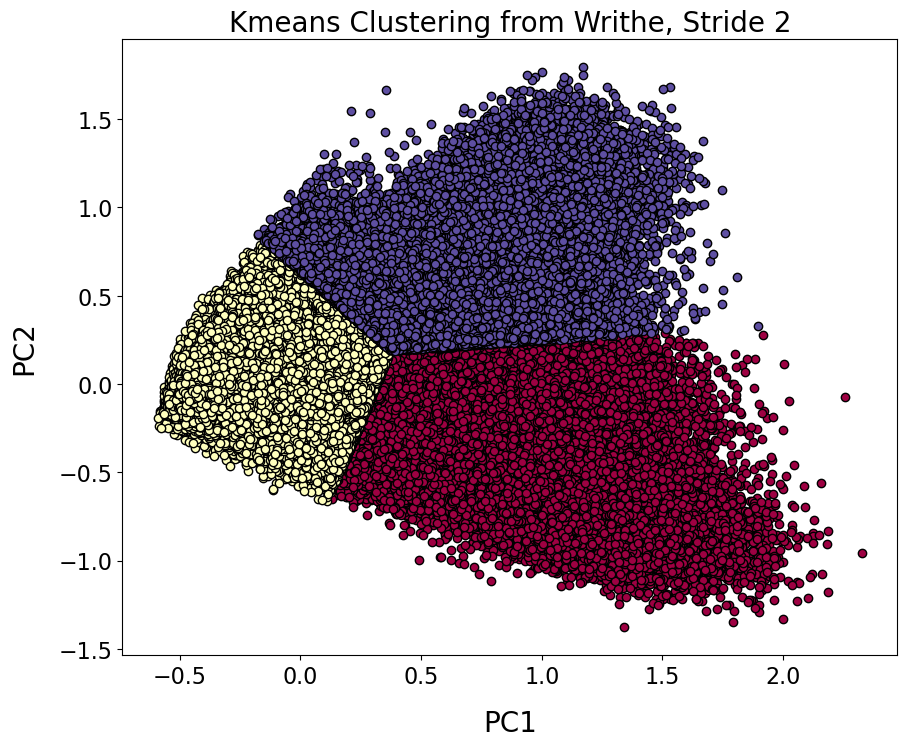

In [59]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )


plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Kmeans Clustering from Writhe, Stride 2", size = 20, loc="center")

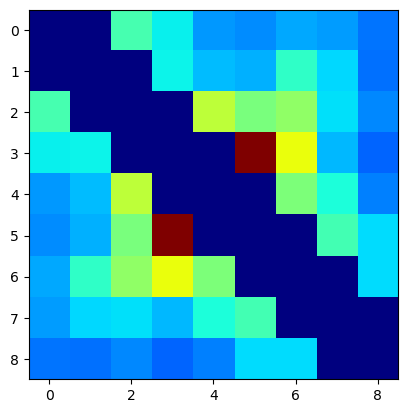

In [60]:
plt.imshow(writhe_matrx_eos, cmap="jet")

In [106]:
reconstructed_matrices_eos = reconstruct_matrx(wmodel_eos,2, 10)
matrx_eos_e1 = reconstructed_matrices_eos[:,:,0]
matrx_eos_e2 = reconstructed_matrices_eos[:,:,1]

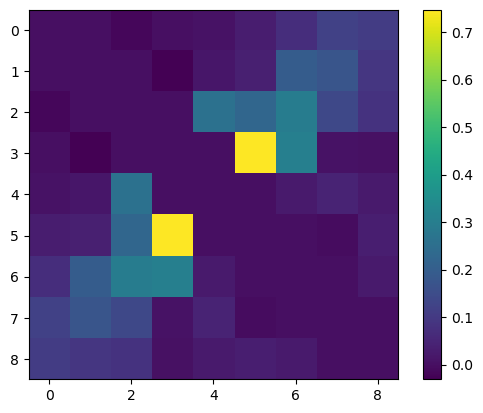

In [107]:
plt.imshow(matrx_eos_e1)
plt.colorbar()

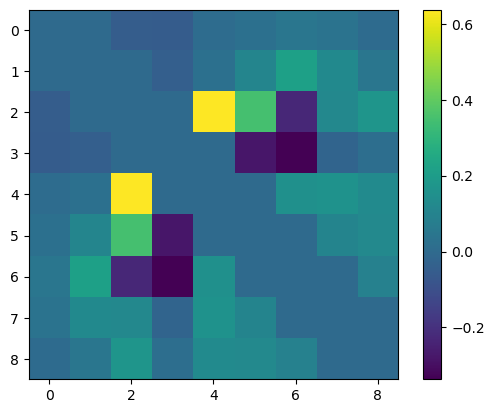

In [108]:
plt.imshow(matrx_eos_e2)
plt.colorbar()

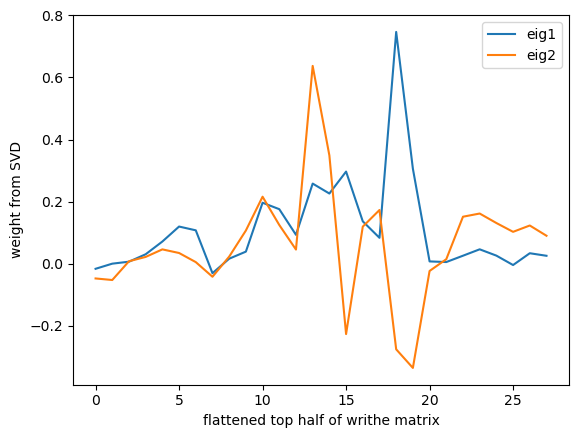

In [117]:
plt.plot(wmodel_eos.components_[0,:], label="eig1")
plt.plot(wmodel_eos.components_[1,:], label="eig2")
plt.xlabel("flattened top half of writhe matrix")
plt.ylabel("weight from SVD")
plt.legend()

9


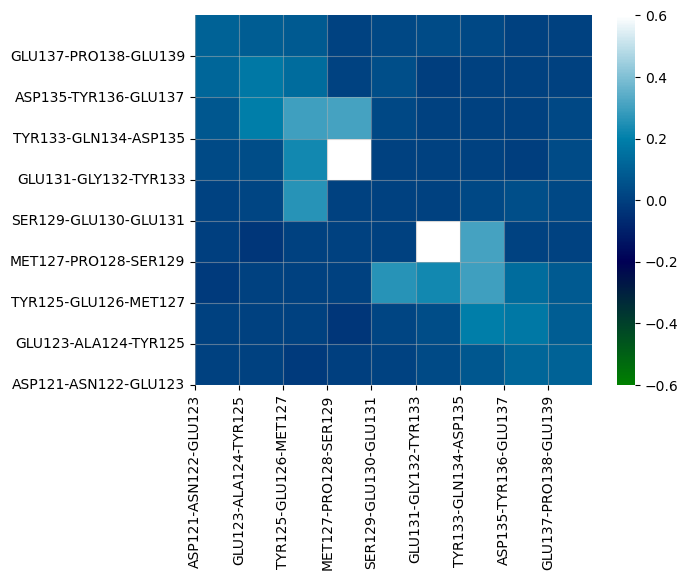

In [130]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

seq=[]
for i in range(0,len(sequence)-2,2): 
    seq.append(str(sequence[i]) + "-"+ str(sequence[i+1]) + "-" + str(sequence[i+2]))

# get rid of some 
n=1
for i in range (0,len(seq)): 
    if (i % n !=0):
        seq[i]=''
        
print(len(seq))

ax = sns.heatmap(matrx_eos_e1, vmin=-0.6, vmax=0.6,cmap='ocean')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,9))
ax.set_yticks(range(0,9))
ax.set_xticklabels(seq,rotation=90)
ax.set_yticklabels(seq,rotation=0)
plt.show()

In [694]:
wr_total_s3, wr_by_res_s3, writhe_matrx_s3, w_model_in_s3 = W_ij_eos(trj,stride=3)

this is the shape of wtot, (555446,)


In [695]:
wmodel_s3 = PCA(n_components=2)
reduced_writhe_s3 = wmodel_s3.fit_transform(w_model_in_s3[:,:-18]) 
WPC1_s3=reduced_writhe_s3[:, 0]
WPC2_s3=reduced_writhe_s3[:,1]

In [696]:
# kmeans analysis
concat = np.column_stack((WPC1_s3, WPC2_s3))
X = concat
kmeans = KMeans(n_clusters=3).fit(X)
labels_s3 = kmeans.labels_
centers_s3 = kmeans.cluster_centers_
scat_s3 = np.split(centers,2, axis=1)

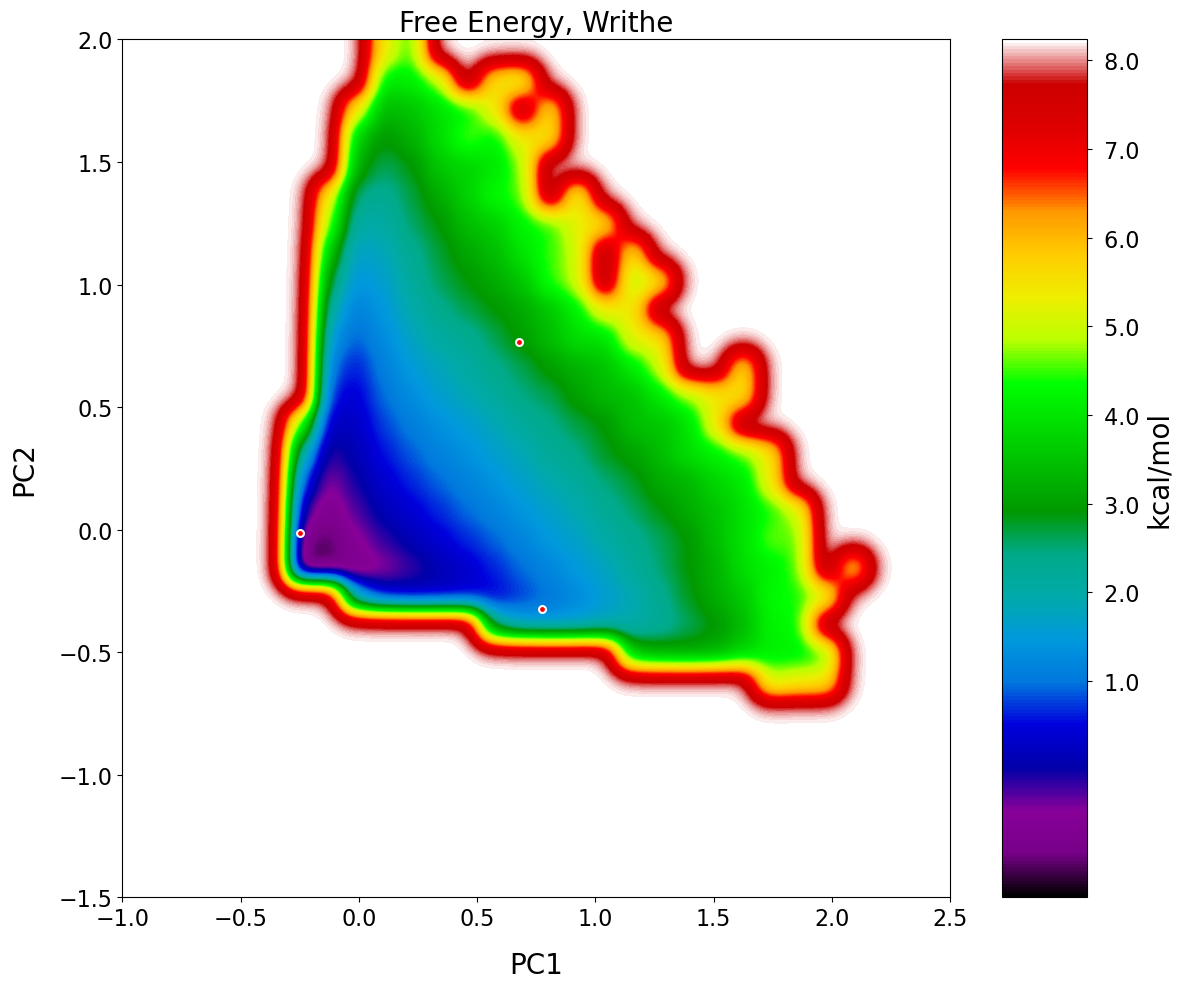

In [697]:
dG,xedges,yedges=free_energy(WPC2_s3, WPC1_s3, 300, -1.5, 2.0, -1, 2.5)

fig = plt.figure(figsize=(12, 10))
# set color 
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap=n_cmap, aspect='auto')
cbar_ticks = [i for i in range(1,9)]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
cb.set_label("kcal/mol", size=20) 

imaxes = plt.gca()
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.title("Free Energy, Writhe", size = 20, loc="center")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(scat[0], scat[1], c="white", marker = "o", s=30)
plt.scatter(scat_s3[0], scat_s3[1], c="red", marker = "o", s=6)
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='16')
plt.tight_layout()

In [118]:
# make smaller segments 
def W_ij_small(trj):
    """
    compute writhe 
    returns: total writhe, writhe by residue, average writhe matrix, and the writhe input 
    """
    CAatoms= trj.topology.select('name CA')
    CApos= trj.xyz[:,CAatoms]
    CAlabel= gen_CA(CAatoms)
    print(CAlabel.shape)
    print(CApos.shape)
    # generate midpoints
    numCA = len(CAlabel)
    n = (numCA) + (numCA-2)
    new_label = np.empty(n)
    new_CApos = np.zeros((trj.n_frames, n, 3))
    
    count = 0
    for i in range(numCA-1):
        new_CApos[:,count,:] = CApos[:,i,:]
        new_label[count] = CAlabel[i]
        
        v = CApos[:,i,:] + CApos[:, i+1,:]
        v = v + 0.000001 # change the vector along all axis a bit for linalg computations 
        
        new_CApos[:,count+1,:] = v/2.0
        new_label[count+1] = CAlabel[i] + 0.5 
        
        #new_CApos[:,count+2,:] = CApos[:,i+1,:]
        #new_label[count+2] = CAlabel[i+1]
        count += 2 
    
    CAlabel = new_label
    CApos = new_CApos
    
    #return new_CApos
    
    #n = len(CAlabel)-1
    #dim = (n-1)(n-2)/2
    #model_input = np.empty((1,trj.n_frames))

    wr_total, model_in= wr_tot(CAlabel, CApos)
    wr_by_res= writhe_by_res(wr_total, CApos)
    writhe_matrx= writhe_avg(wr_total, CAlabel)
    return wr_total, wr_by_res, writhe_matrx, model_in

In [119]:
wr_total_small, wr_by_res_small, writhe_matrx_small, w_model_in_small = W_ij_small(trj)

(20,)
(555446, 20, 3)
this is the shape of wtot, (555446,)


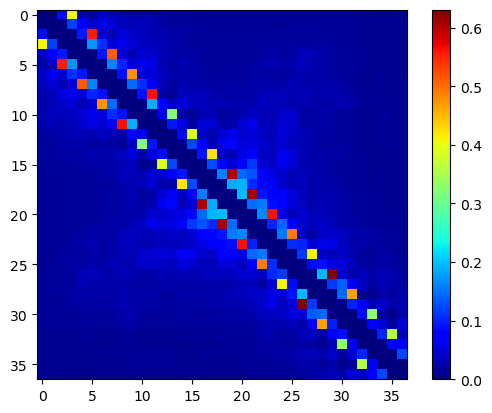

In [131]:
plt.imshow(writhe_matrx_small, cmap="jet")
plt.colorbar()

In [132]:
wmodel_small = PCA(n_components=2)
reduced_writhe_small = wmodel_small.fit_transform(w_model_in_small) 
WPC1_small=reduced_writhe_small[:,0]
WPC2_small=reduced_writhe_small[:,1]

In [133]:
wmodel_small.explained_variance_ratio_

array([0.06615117, 0.0579497 ])

In [134]:
np.sum(wmodel_small.explained_variance_ratio_)

0.12410087080190467

In [136]:
reconstructed_matrices_small = reconstruct_matrx(wmodel_small,2, 37)
matrx_small_e1 = reconstructed_matrices_small[:,:,0]
matrx_small_e2 = reconstructed_matrices_small[:,:,1]

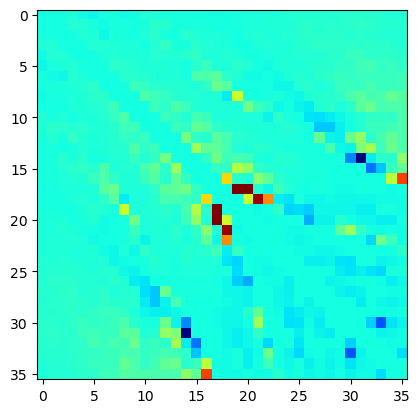

In [138]:
plt.imshow(matrx_small_e1, cmap="jet")

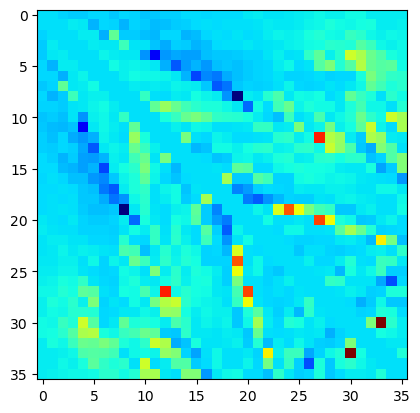

In [139]:
plt.imshow(matrx_small_e2, cmap="jet")

In [144]:
# kmeans
concat = np.column_stack((WPC1_small, WPC2_small))
X = concat
kmeans = KMeans(n_clusters=3).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
scat = np.split(centers,2, axis=1)

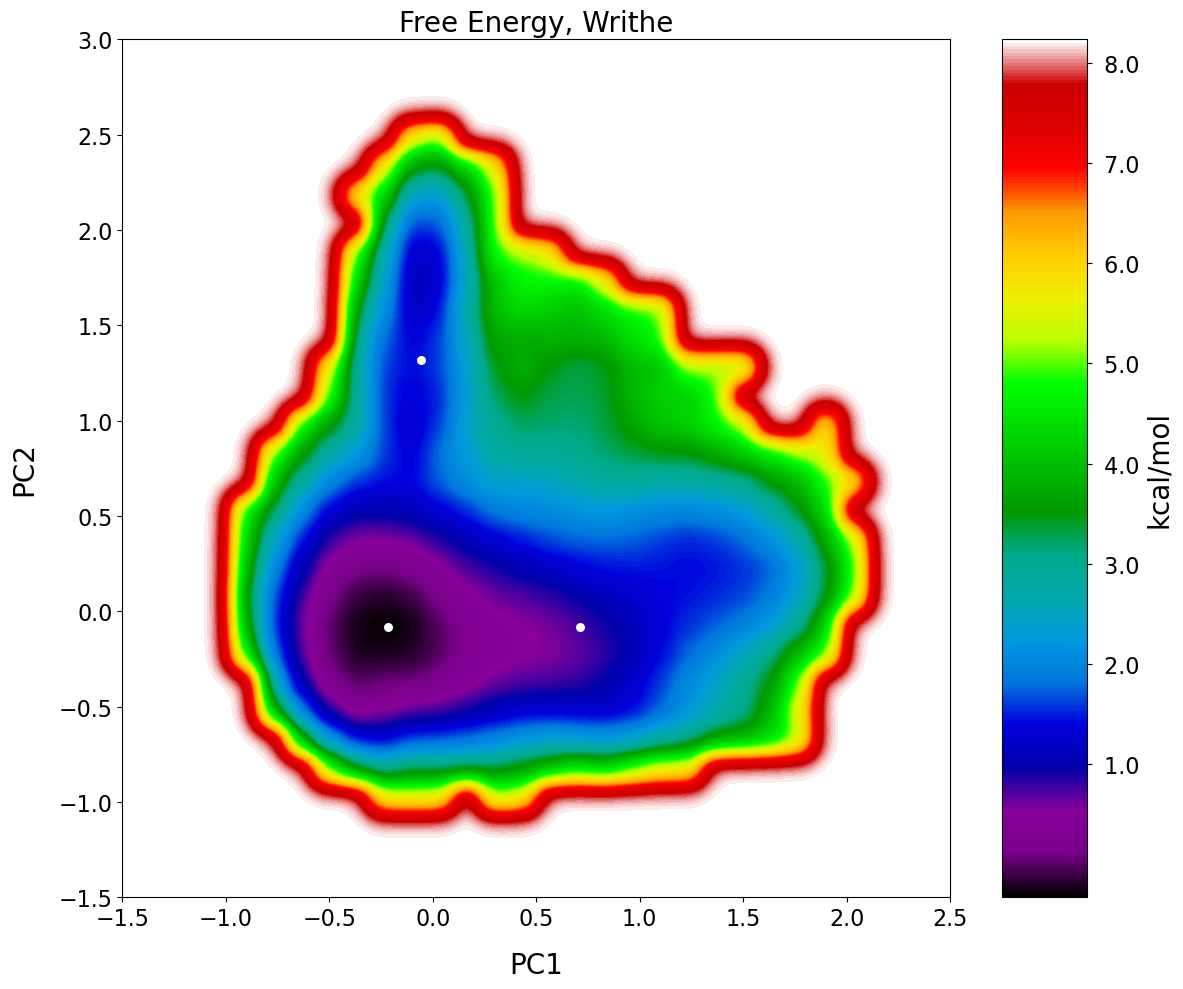

In [145]:
dG,xedges,yedges=free_energy(WPC2_small, WPC1_small, 300, -1.5, 3.0, -1.5, 2.5)

fig = plt.figure(figsize=(12, 10))
# set color 
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap=n_cmap, aspect='auto')
cbar_ticks = [i for i in range(1,9)]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
cb.set_label("kcal/mol", size=20) 

imaxes = plt.gca()
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.title("Free Energy, Writhe", size = 20, loc="center")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(scat[0], scat[1], c="white", marker = "o", s=30)
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='16')
plt.tight_layout()

Text(0.5, 1.0, 'Kmeans Clustering from Writhe, Midpoints')

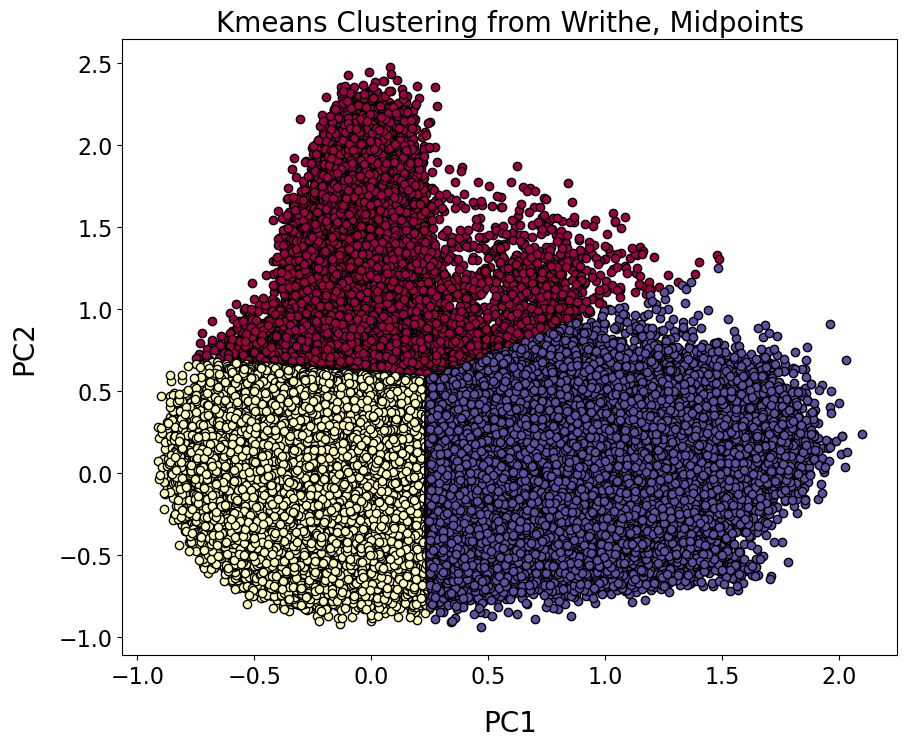

In [147]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )


plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Kmeans Clustering from Writhe, Midpoints", size = 20, loc="center")

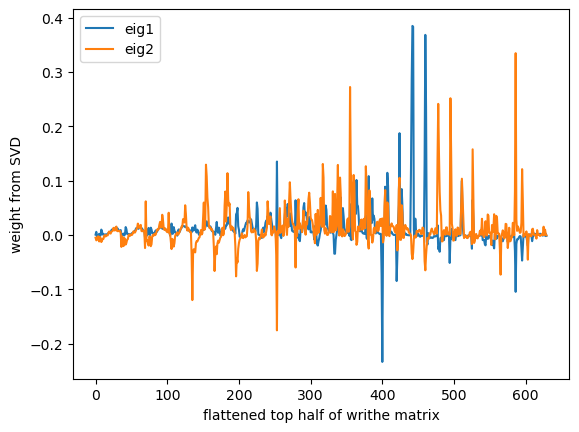

In [148]:
plt.plot(wmodel_small.components_[0,:], label="eig1")
plt.plot(wmodel_small.components_[1,:], label="eig2")
plt.xlabel("flattened top half of writhe matrix")
plt.ylabel("weight from SVD")
plt.legend()

In [ ]:
# find the frame indices w/o a clustering algorithm 
    
# f_pc1_basin1 = np.where((-0.5 < WPC1) & (WPC1< 0.5))
# f_pc2_basin1 = np.where((WPC2 > -0.5)& (WPC2 < 0.5))
# writhe_basin1_ind = np.intersect1d(f_pc1_basin1, f_pc2_basin1)

# f_pc1_basin2 = np.where((0.5 < WPC1) & (WPC1 < 1.5))
# f_pc2_basin2 = np.where((-1 < WPC2)& (WPC2 < 0))
# writhe_basin2_ind = np.intersect1d(f_pc1_basin2, f_pc2_basin2)

# f_pc1_basin3 = np.where((0.5 < WPC1) & (WPC1 < 1.2))
# f_pc2_basin3 = np.where((1.0 < WPC2)& (WPC2 < 1.8))
# writhe_basin3_ind = np.intersect1d(f_pc1_basin3, f_pc2_basin3)

# print("Percentage of basin 1:", writhe_basin1_ind.size/trj.n_frames *100)
# print("Percentage of basin 2:", writhe_basin2_ind.size/trj.n_frames *100)
# print("Percentage of basin 3:", writhe_basin3_ind.size/trj.n_frames *100)

In [ ]:
# writhe_basin1_trj = trj.slice(writhe_basin1_ind)
# writhe_basin1_trj.save_dcd("./outdir/writhe_basin1_trj.dcd")
# writhe_basin1_trj = trj.slice(writhe_basin2_ind)
# writhe_basin1_trj.save_dcd("./outdir/writhe_basin2_trj.dcd")
# writhe_basin1_trj = trj.slice(writhe_basin3_ind)
# writhe_basin1_trj.save_dcd("./outdir/writhe_basin3_trj.dcd")

(array([2.1000e+01, 2.9000e+01, 2.8000e+01, 1.3000e+01, 4.4000e+01,
        6.8000e+01, 9.0000e+00, 6.5200e+02, 1.3000e+01, 3.6000e+01,
        4.2000e+01, 2.0000e+00, 4.3000e+01, 2.2000e+01, 1.3600e+02,
        9.0000e+01, 1.9000e+01, 2.3000e+01, 1.5000e+01, 2.7000e+01,
        2.5000e+01, 1.6000e+01, 1.6000e+01, 1.7000e+01, 2.7000e+01,
        1.0000e+00, 4.3000e+01, 3.5630e+03, 1.0973e+04, 1.1046e+04,
        2.8150e+03, 6.7000e+01, 2.1000e+01, 1.0000e+01, 6.0000e+00,
        1.9000e+01, 2.5000e+01, 7.7000e+01, 2.5000e+01, 4.7000e+01,
        2.1000e+01, 1.1000e+01, 1.3000e+01, 2.2000e+01, 8.0000e+00,
        8.0000e+00, 3.1800e+02, 8.7000e+01, 1.2000e+01, 3.9000e+01]),
 array([3.870000e+02, 1.148540e+04, 2.258380e+04, 3.368220e+04,
        4.478060e+04, 5.587900e+04, 6.697740e+04, 7.807580e+04,
        8.917420e+04, 1.002726e+05, 1.113710e+05, 1.224694e+05,
        1.335678e+05, 1.446662e+05, 1.557646e+05, 1.668630e+05,
        1.779614e+05, 1.890598e+05, 2.001582e+05, 2.112566e+05

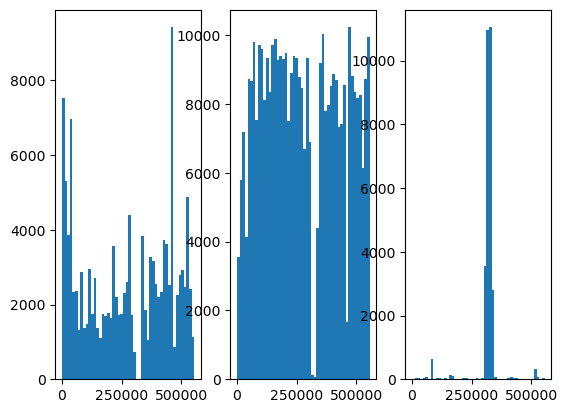

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex="all")
ax1.hist(wbasin1, bins=50)
ax2.hist(wbasin2, bins=50)
ax3.hist(wbasin3, bins=50)

In [49]:
def writhe_avg_from_ind(wr_total, CAlabel, np_ind): 
    """
    computes the writhe average from indices 
    output: numpy array of averages 
    """
    writhe_matrx= np.zeros((len(CAlabel)-1,len(CAlabel)-1))
    np_empty = np.empty(np_ind.size,)
    
    for j in wr_total:
        for k in wr_total[j]:
            for n,i in enumerate(np_ind): 
                if type(wr_total[j][k]) == int: 
                    np_empty[n] = 0
                else:  
                    np_empty[n] = wr_total[j][k][i] # a faster way is to make a mask and remove zero values
            writhe_matrx[j,k]= np.average(np_empty)
            writhe_matrx[k,j]= writhe_matrx[j,k]
    return writhe_matrx

In [50]:
CAatoms= trj.topology.select('name CA')
CApos= trj.xyz[:,CAatoms]
CAlabel= gen_CA(CAatoms)
writhe_basin1 = writhe_avg_from_ind(wr_total, CAlabel, wbasin1)
writhe_basin2 = writhe_avg_from_ind(wr_total, CAlabel, wbasin2)
writhe_basin3 = writhe_avg_from_ind(wr_total, CAlabel, wbasin3)

In [87]:
print(wbasin1.size, wbasin2.size, wbasin3.size)

132568 392168 30710


In [92]:
wbasin1[:-1:5000].size

27

In [397]:
writhe_basin1.shape

(19, 19)

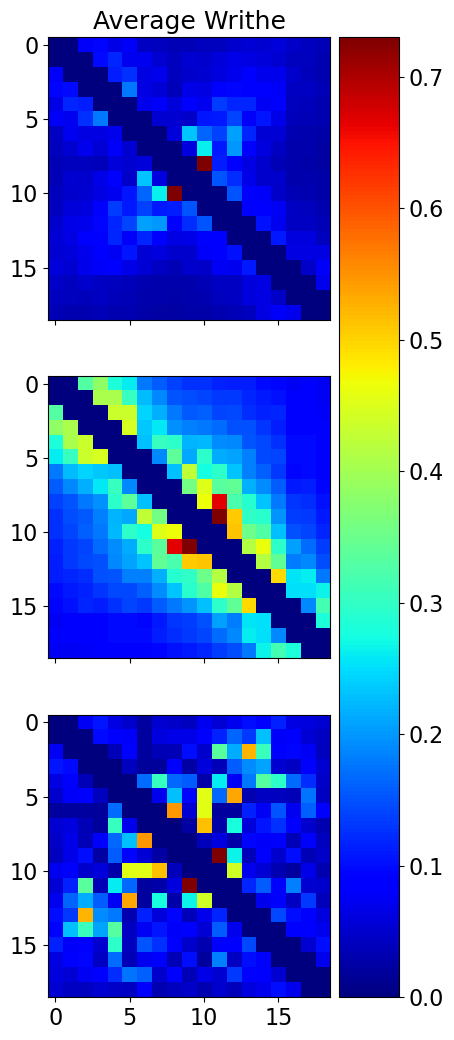

In [299]:
fig, (ax1) = plt.subplots(3,1, sharex= "all", sharey="all", figsize=[8, 12])
plt.subplot(311)
plt.imshow(writhe_basin1,cmap="jet")
plt.title("Average Writhe", size=18)
plt.xticks(np.arange(0, 19, step=5), size=16)
plt.yticks(np.arange(0, 19, step=5), size=16)
plt.subplot(312)
plt.imshow(writhe_basin2,cmap="jet")
plt.xticks(size=16)
plt.yticks(size=16)
plt.subplot(313)
plt.imshow(writhe_basin3,cmap="jet")
plt.xticks(size=16)
plt.yticks(size=16)

plt.subplots_adjust(bottom=0.1, right=1.2, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.yticks(size=16)
#plt.ylabel("Writhe", size=16, rotation=270)
plt.savefig("./outdir/average_writhe_per_basin.png", dpi=200)

In [262]:
# average contacts for the identified basins with PCA on Writhe
contact_basin1_wpca = contact_map_avg(contacts, 20, wbasin1)
contact_basin2_wpca = contact_map_avg(contacts, 20, wbasin2)
contact_basin3_wpca = contact_map_avg(contacts, 20, wbasin3)

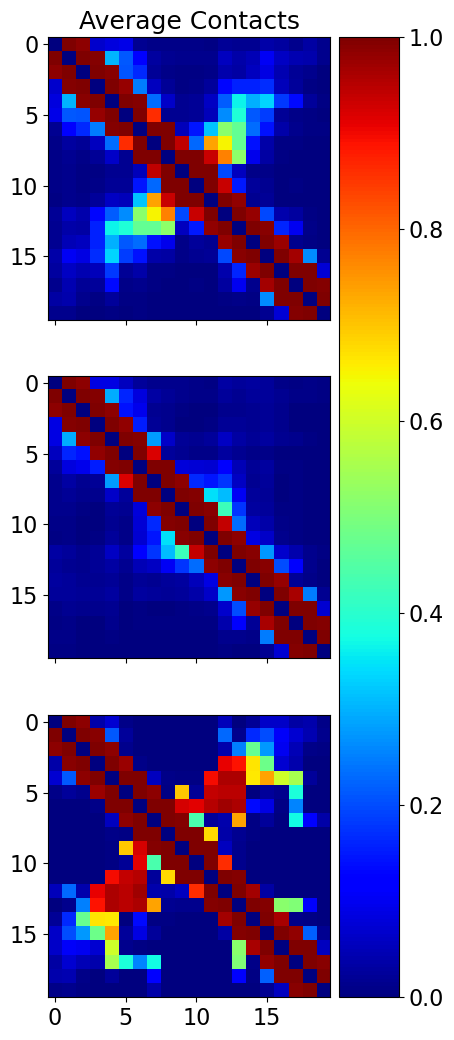

In [291]:
# average contacts for the identified basins with PCA on Writhe
#plt.figure(figsize=(8,16))
# ax1[0].imshow(contact_basin1_wpca,cmap="jet")
# ax1[0].set_title("Average Contacts Basin 1")
# ax1[1].imshow(contact_basin2_wpca,cmap="jet")
# ax1[1].set_title("Average Contacts Basin 2")
# ax1[2].imshow(contact_basin3_wpca,cmap="jet")
# ax1[2].set_title("Average Contacts Basin 3")

fig, (ax1) = plt.subplots(3,1, sharex= "all", sharey="all", figsize=[8, 12])
plt.subplot(311)
plt.imshow(contact_basin1_wpca,cmap="jet")
plt.title("Average Contacts", size=18)
plt.xticks(np.arange(0, 19, step=5), size=16)
plt.yticks(np.arange(0, 19, step=5), size=16)
plt.subplot(312)
plt.imshow(contact_basin2_wpca,cmap="jet")
plt.xticks(size=16)
plt.yticks(size=16)
plt.subplot(313)
plt.imshow(contact_basin3_wpca,cmap="jet")
plt.xticks(size=16)
plt.yticks(size=16)

plt.subplots_adjust(bottom=0.1, right=1.2, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.yticks(size=16)
plt.savefig("./outdir/average_contacts_per_basin_from_writhe_pca.png", dpi=200)

In [ ]:
def make_contact_distance_map(res_num):
    """
    All elements to create a contact map 
    returns: (np.array) model input for PCA, contact average, and total contacts 
    """
    contacts = np.zeros(shape=(res_num,res_num,trj.n_frames))
    contact_avg = np.zeros(shape=(res_num,res_num))
    
    dim = int((res_num)*(res_num - 1)/2)
    model_in = np.zeros(shape=(dim, trj.n_frames))
    count = 0
    
    for i in range(0, 20):
        for j in range(i+1, 20):
            contacts[i][j] = md.compute_contacts(trj,[[i,j]])[0].reshape(555445,)
            #
            contacts[j][i] = contacts[i][j]
             
            contact_avg[i][j] = np.average(contacts[i][j])
            contact_avg[j][i] = contact_avg[i][j] 
            
            model_in[count] = contacts[i][j]
            count += 1
    # transpose
    model_in = np.transpose(model_in)
    return model_in, contacts, contact_avg

In [ ]:
# # make half of the matrix and duplicate ~ might not be exactly right for every atom 
# def make_contact_map(res_num=20):
#     """
#     All elements to create a contact map 
#     returns: (np.array) model input for PCA, contact average, and total contacts 
#     """
#     contacts = np.zeros(shape=(res_num,res_num,trj.n_frames))
#     contact_avg = np.zeros(shape=(res_num,res_num))
    
#     dim = int((res_num)*(res_num - 1)/2)
#     model_in = np.zeros(shape=(dim, trj.n_frames))
#     count = 0
    
#     for i in range(0, res_num):
#         for j in range(i+1, res_num):
#             contacts[i][j] = np.where(md.compute_contacts(trj,[[i,j]])[0] < 0.5, 1, 0).reshape(trj.n_frames)
#             contacts[j][i] = contacts[i][j]
             
#             contact_avg[i][j] = np.average(contacts[i][j])
#             contact_avg[j][i] = contact_avg[i][j] 
            
#             model_in[count] = contacts[i][j]
#             count += 1
    
#     # transpose
#     model_in = np.transpose(model_in)
#     return model_in, contacts, contact_avg

In [153]:
def make_contact_map(res_num=20):
    """
    All elements to create a contact map 
    returns: (np.array) model input for PCA, contact average, and total contacts 
    """
    contacts = np.zeros(shape=(res_num,res_num,trj.n_frames))
    contact_avg = np.zeros(shape=(res_num,res_num))
    
    #dim = int((res_num)*(res_num - 1)/2)
    model_in = np.zeros(shape=((res_num*res_num), trj.n_frames))
    
    count = 0 
    for i in range(0, res_num):
        for j in range(0, res_num):
            if i == j: 
                contacts[i][j] = 0
            else: 
                contacts[i][j] = np.where(md.compute_contacts(trj,[[i,j]])[0] < 0.5, 1, 0).reshape(trj.n_frames)
                contact_avg[i][j] = np.average(contacts[i][j])

            model_in[count] = contacts[i][j]
            count += 1
    
    # transpose
    model_in = np.transpose(model_in)
    return model_in, contacts, contact_avg

In [154]:
c_model_in, contacts, contact_avg = make_contact_map(res_num=20)

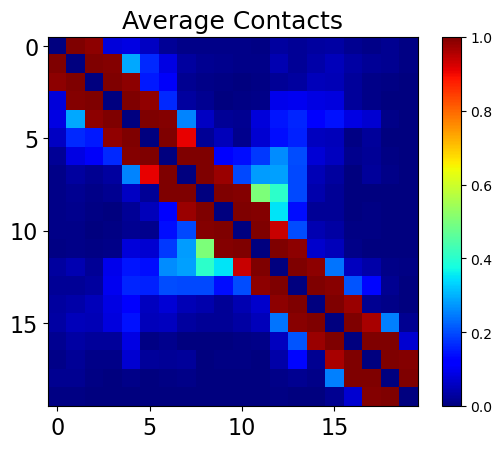

In [159]:
#plt.figure(figsize=(10,10))
plt.imshow(contact_avg, cmap="jet")
plt.title("Average Contacts", size=18)
plt.xticks(np.arange(0, 20, step=5), size=16)
plt.yticks(np.arange(0, 20, step=5), size=16)
plt.colorbar()

In [54]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
print(sequence)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
    if (i % n !=0):
        sequence[i]=''
print(sequence)

[ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140]
[ASP121, '', GLU123, '', TYR125, '', MET127, '', SER129, '', GLU131, '', TYR133, '', ASP135, '', GLU137, '', GLU139, '']


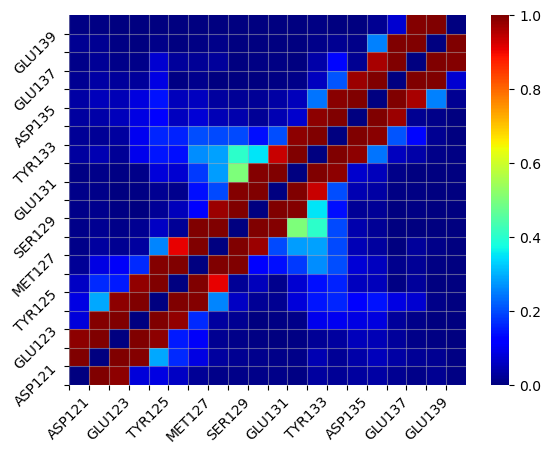

<Figure size 640x480 with 0 Axes>

In [86]:
ax = sns.heatmap(contact_avg, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,20))
ax.set_yticks(range(0,20))
ax.set_xticklabels(sequence,rotation=45)
ax.set_yticklabels(sequence,rotation=45)
plt.show()
plt.savefig("./outdir/average_contacts.png", dpi=200)

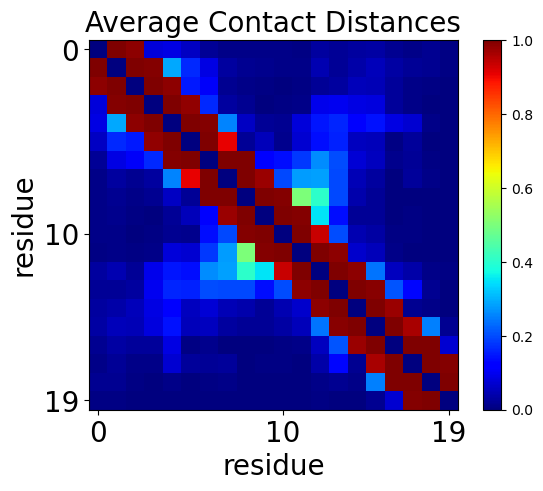

In [58]:
#x_axis=np.linspace(121,140,20) trying to show actual res number
plt.imshow(contact_avg,cmap='jet',label="Average Contact Distances")
plt.xlabel("residue", size=20)
plt.ylabel("residue", size=20)
plt.xticks(ticks=[0, 10, 19], size=20)
plt.yticks(ticks=[0, 10, 19], size=20)
plt.title("Average Contact Distances", loc="center", size=20)
plt.colorbar()

In [60]:
trj.superpose(trj, 0)
cmodel = PCA(n_components=2)
reduced_contacts = cmodel.fit_transform(c_model_in) 
CPC1=reduced_contacts[:, 0]
CPC2=reduced_contacts[:,1]

In [ ]:
plt.plot(cmodel.components_[0,:], label="eig1")
plt.plot(cmodel.components_[1,:], label="eig2")
plt.xlabel("flattened contacts matrix")
plt.ylabel("Weights from SVD")
plt.legend()

In [ ]:
eig1=np.reshape(cmodel.components_[0,:], (20, 20))
ax = sns.heatmap(eig1, vmin=-0.31, vmax=0.21,cmap='ocean')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,20))
ax.set_yticks(range(0,20))
ax.set_xticklabels(sequence,rotation=45)
ax.set_yticklabels(sequence,rotation=45)
plt.show()

In [ ]:
eig2=np.reshape(cmodel.components_[1,:], (20, 20))
ax = sns.heatmap(eig2, vmin=-0.31, vmax=0.21,cmap='ocean')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,20))
ax.set_yticks(range(0,20))
ax.set_xticklabels(sequence,rotation=45)
ax.set_yticklabels(sequence,rotation=45)
plt.show()

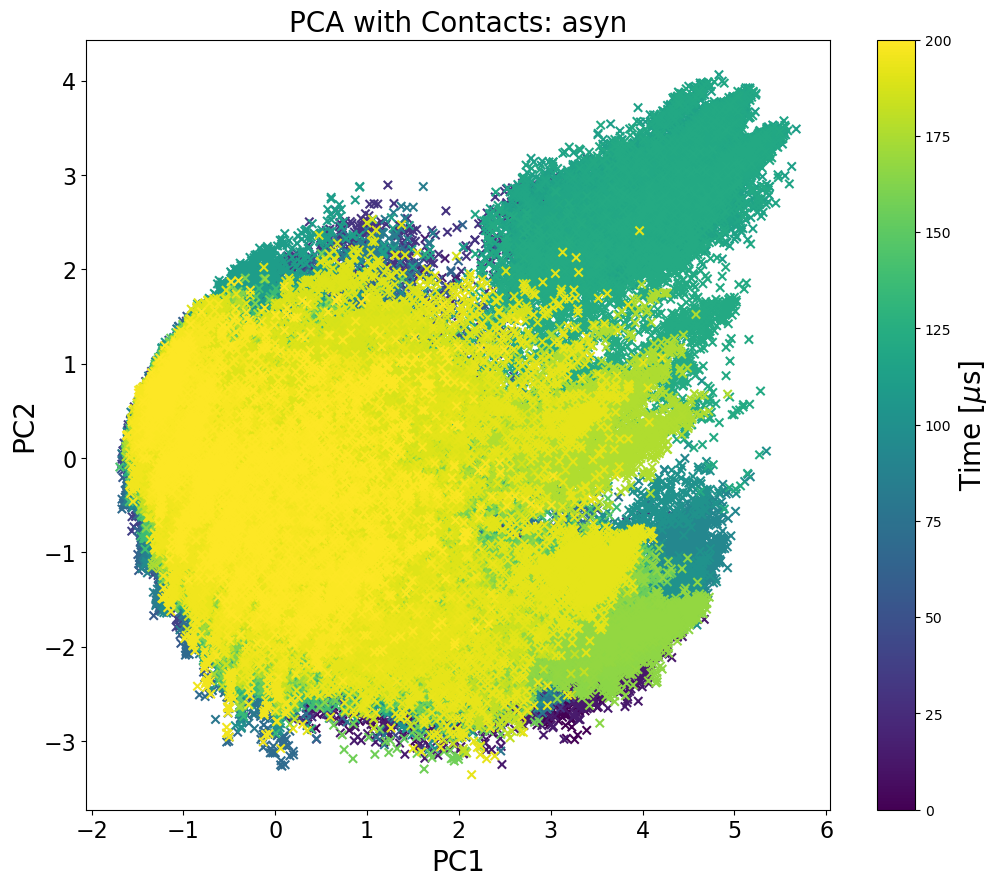

In [61]:
#time
time=np.linspace(0,200,trj.n_frames)
plt.figure(figsize=(12,10))
plt.scatter(CPC1, CPC2, marker='x', c=time)
plt.xlabel('PC1',size=20)
plt.ylabel('PC2',size=20) 
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('PCA with Contacts: asyn', size=20)
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]',size=20)

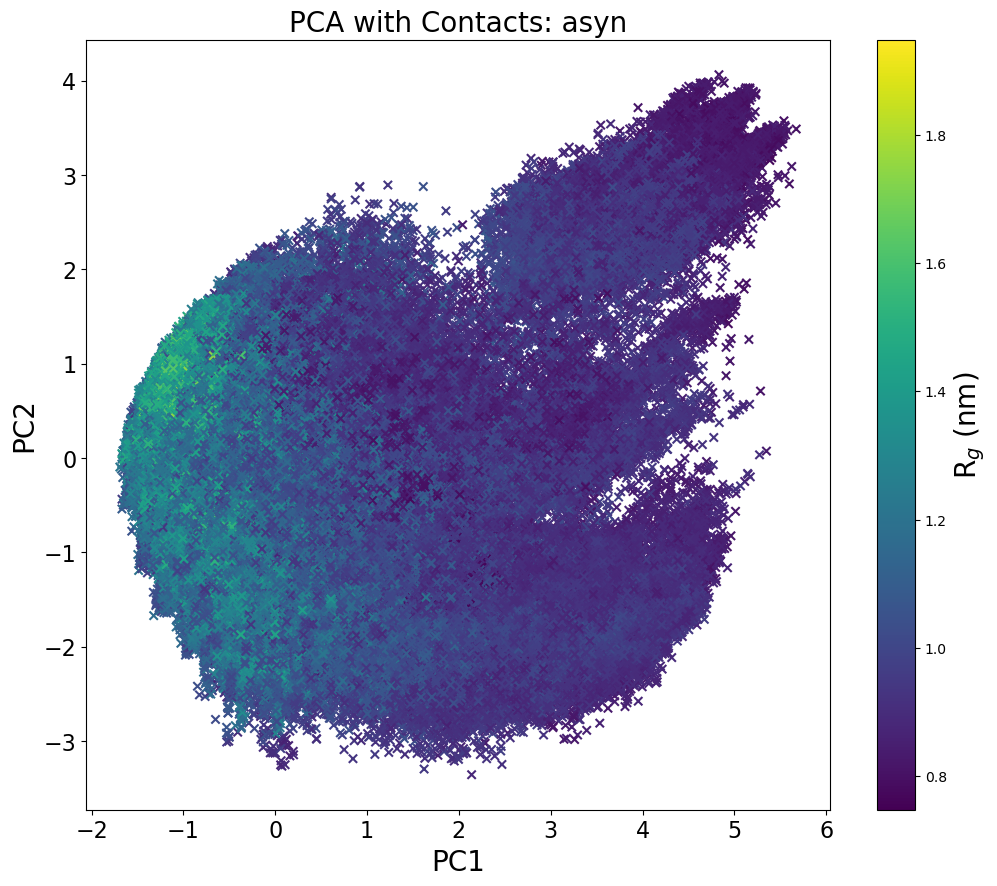

In [62]:
# gyration
plt.figure(figsize=(12,10))
plt.scatter(CPC1, CPC2, marker='x', c=rg)
plt.xlabel('PC1', size=20)
plt.xticks(size=16)
plt.ylabel('PC2', size=20) 
plt.yticks(size=16)
plt.title('PCA with Contacts: asyn', size=20)
cbar = plt.colorbar()
cbar.set_label('R$_g$ (nm)', size=20)

In [185]:
from sklearn.cluster import KMeans
concat = np.column_stack((CPC1, CPC2))
X = concat
kmeans = KMeans(n_clusters=3).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
scat = np.split(centers,2, axis=1)

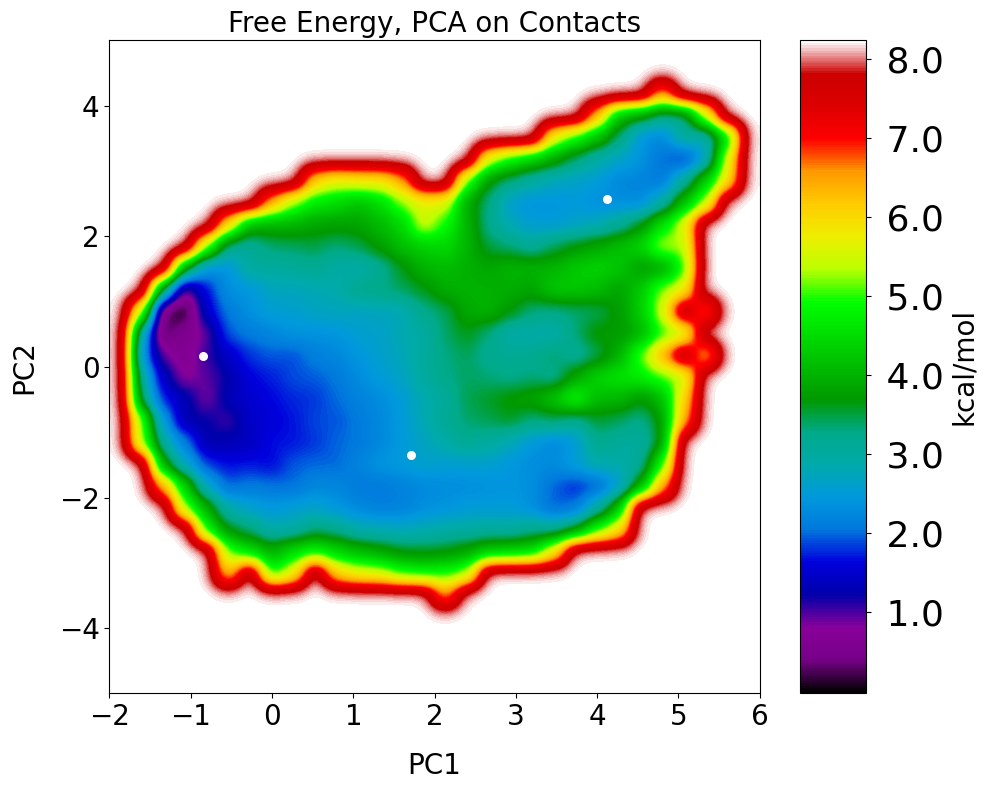

In [192]:
dG,xedges,yedges=free_energy(CPC2, CPC1, 300, -5, 5, -2, 6)

fig = plt.figure(figsize=(10, 8))
# set color 
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap=n_cmap, aspect='auto')
cbar_ticks = [i for i in range(1,9)]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
cb.set_label("kcal/mol", size=20) 

imaxes = plt.gca()
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.title("Free Energy, PCA on Contacts", size = 20, loc="center")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.scatter(scat[0], scat[1], c="white", marker = "o", s=30)
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

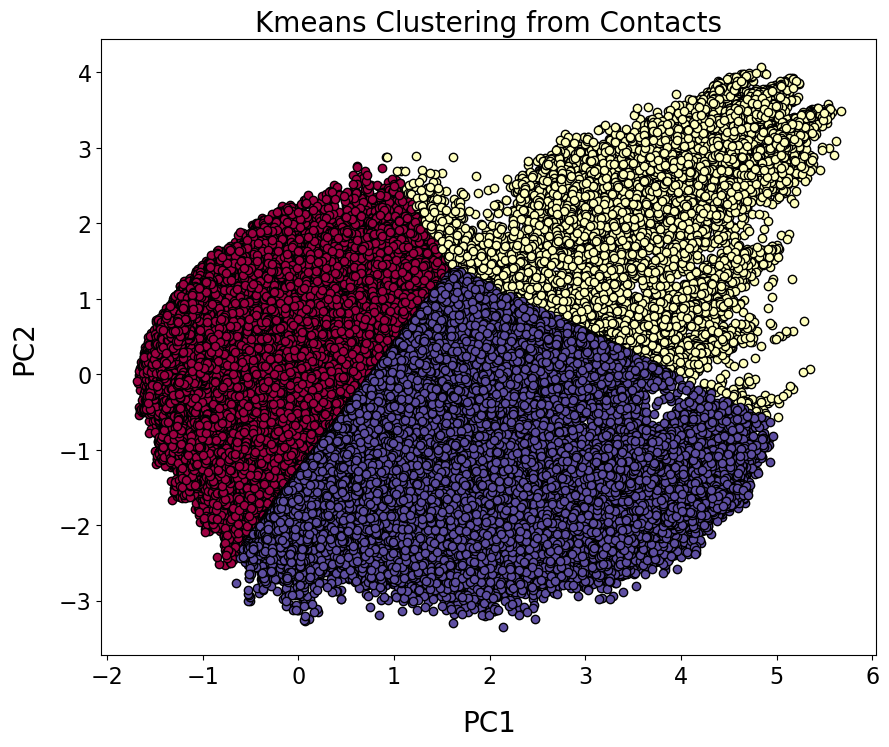

In [193]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig = plt.figure(figsize=(10,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask] #  & core_samples_mask for dbscan
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

    """xy = X[class_member_mask] #  & ~core_samples_mask
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )"""
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Kmeans Clustering from Contacts", size = 20, loc="center")
plt.savefig('./outdir/writhe_kmeans_clustering.png',dpi=200)

In [ ]:
# # find the frame indices, this is for contact distances 
    
# f_cpc1_basin1 = np.where((-3 < CPC1) & (CPC1< 1))
# f_cpc2_basin1 = np.where((CPC2 > -2.5)& (CPC2 < 2.5))
# contact_basin1_ind = np.intersect1d(f_cpc1_basin1, f_cpc2_basin1)

# f_cpc1_basin2 = np.where((2.5 < CPC1) & (CPC1 < 6))
# f_cpc2_basin2 = np.where((-3 < CPC2)& (CPC2 < 0.0))
# contact_basin2_ind = np.intersect1d(f_cpc1_basin2, f_cpc2_basin2)

# f_cpc1_basin3 = np.where((6 < CPC1) & (CPC1 < 8))
# f_cpc2_basin3 = np.where((0.0 < CPC2)& (CPC2 < 2.5))
# contact_basin3_ind = np.intersect1d(f_cpc1_basin3, f_cpc2_basin3)

# print("Percentage of basin 1:", contact_basin1_ind.size/trj.n_frames *100)
# print("Percentage of basin 2:", contact_basin2_ind.size/trj.n_frames *100)
# print("Percentage of basin 3:", contact_basin3_ind.size/trj.n_frames *100)

In [194]:
def contact_map_avg(con, res_num, np_ind):
    contact_avg = np.zeros(shape=(res_num,res_num))
    np_empty = np.empty(np_ind.size,)
    for i in range(res_num):
        for j,nparr in enumerate(con[i]):
            for num, k in enumerate(np_ind): 
                np_empty[num] = nparr[k] # contacts[i][j][k]
            contact_avg[i,j] = np.average(np_empty)
    return contact_avg

In [195]:
cbasin1 = np.where(labels == 0)[0]
cbasin2 = np.where(labels == 1)[0]
cbasin3 = np.where(labels == 2)[0]
contacts_basin_trj = trj.slice(cbasin1)
contacts_basin_trj.save_dcd("./outdir/kmeans_contacts_basin1_trj.dcd")
contacts_basin_trj = trj.slice(cbasin2)
contacts_basin_trj.save_dcd("./outdir/kmeans_contacts_basin2_trj.dcd")
contacts_basin_trj = trj.slice(cbasin3)
contacts_basin_trj.save_dcd("./outdir/kmeans_contacts_basin3_trj.dcd")

In [200]:
cbasin1.size/27

14971.888888888889

In [209]:
cbasin1.size/4000

101.06025

In [210]:
# get centroids 
traj_basin = md.load("./outdir/kmeans_contacts_basin1_trj.dcd", top=pdb, stride=101)
atom_indices = [a.index for a in traj_basin.topology.atoms if a.element.symbol != 'H']
distances = np.empty((traj_basin.n_frames, traj_basin.n_frames))
for i in range(traj_basin.n_frames):
    distances[i] = md.rmsd(traj_basin, traj_basin, i, atom_indices=atom_indices)

beta = 1
index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
print(index)

centroid = traj_basin[index]
print(centroid)

2786
<mdtraj.Trajectory with 1 frames, 294 atoms, 21 residues, and unitcells>


Centroids for Contacts, 4000 frames input 
basin 1: 2786
basin 2: 585 
basin 3: 214

In [196]:
contact_basin1 = contact_map_avg(contacts, 20, cbasin1)
contact_basin2 = contact_map_avg(contacts, 20, cbasin2)
contact_basin3 = contact_map_avg(contacts, 20, cbasin3)

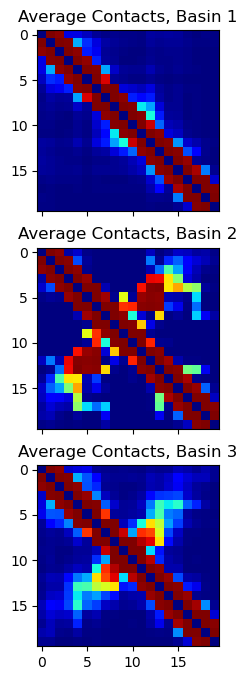

In [197]:
fig, (ax1) = plt.subplots(3,1, sharex= "all", figsize=[10, 8])
ax1[0].imshow(contact_basin1,cmap="jet")
ax1[0].set_title("Average Contacts, Basin 1")
ax1[1].imshow(contact_basin2,cmap="jet")
ax1[1].set_title("Average Contacts, Basin 2")
ax1[2].imshow(contact_basin3,cmap="jet")
ax1[2].set_title("Average Contacts, Basin 3")
plt.savefig("./outdir/average_contacts_per_basin.png", dpi=200)

In [211]:
import math
    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [213]:
trj

<mdtraj.Trajectory with 555446 frames, 294 atoms, 20 residues, and unitcells at 0x7fde2bf79310>

/var/folders/jj/7281gv9s0hjdcyjcdls8ygqc0000gn/T/ipykernel_10100/3440810289.py:30: RuntimeWarning: invalid value encountered in divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


<ErrorbarContainer object of 3 artists>

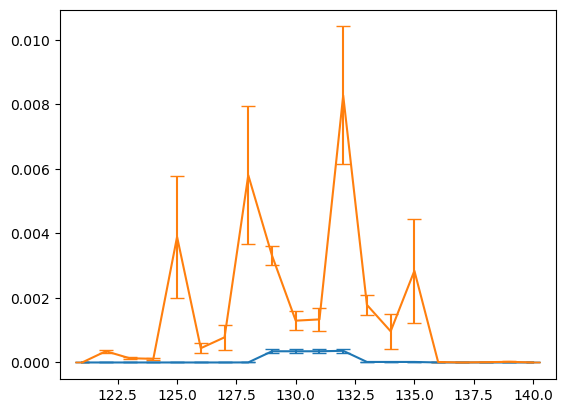

In [212]:
dssp=md.compute_dssp(trj, simplified=True)
#np.savetxt(wdir+"/dssp.out",dssp,fmt='%s')

dsspH=np.copy(dssp)
dsspE=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
#np.savetxt(wdir+"/dssp.HTOT.dat",TotalH,fmt='%i')

#Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
SE_H=np.zeros((len(CAlabel),2))

for i in range(0,len(CAlabel)): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 


dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
TotalE=np.sum(dsspE,axis=1) 

Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
SE_E=np.zeros((len(CAlabel),2))

for i in range(0,len(CAlabel)):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
    
plt.errorbar(CAlabel,SE_H[:,0],yerr=SE_H[:,1], capsize=5)
plt.errorbar(CAlabel,SE_E[:,0],yerr=SE_E[:,1], capsize=5)

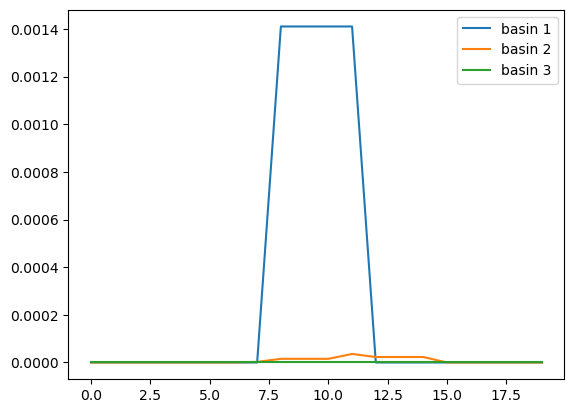

In [214]:
plt.plot(np.mean(dsspH[wbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspH[wbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspH[wbasin3],axis=0),label='basin 3')
plt.legend()

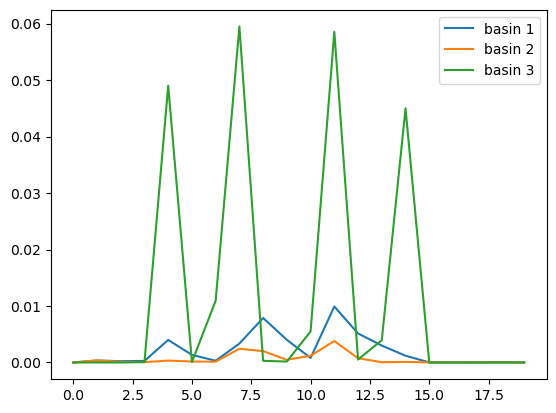

In [217]:
plt.plot(np.mean(dsspE[wbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspE[wbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspE[wbasin3],axis=0),label='basin 3')
plt.legend()

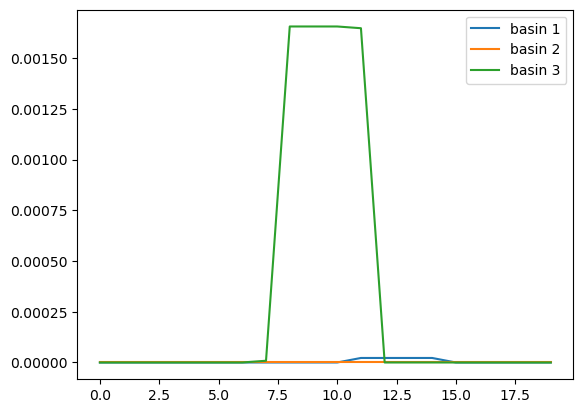

In [216]:
plt.plot(np.mean(dsspH[cbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspH[cbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspH[cbasin3],axis=0),label='basin 3')
plt.legend()

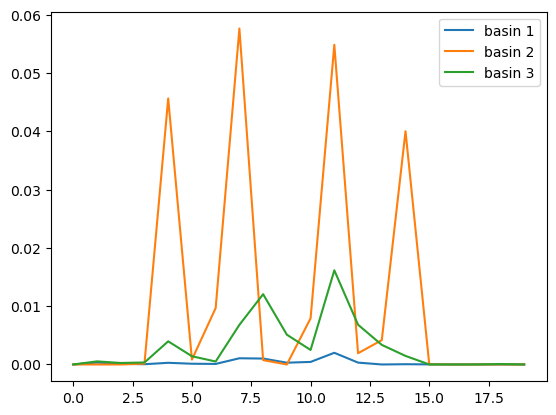

In [218]:
plt.plot(np.mean(dsspE[cbasin1],axis=0),label='basin 1')
plt.plot(np.mean(dsspE[cbasin2],axis=0),label='basin 2')
plt.plot(np.mean(dsspE[cbasin3],axis=0),label='basin 3')
plt.legend()

Anything beyond this, is just experimenting, no need to look further

In [83]:
# save, because I did the analysis with a different topology file, I'll need to save the toplogy 
# trj[0].save_pdb("./outdir/new_top.pdb")

In [ ]:
# dG,xedges,yedges=free_energy(WPC1, CPC1, 300, -10, 10, -10, 10)

# fig = plt.figure(figsize=(8, 6))
# # set color 
# im = plt.imshow(dG, interpolation='gaussian', extent=[
#                 yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='nipy_spectral', aspect='auto')
# cbar_ticks = [i for i in range(1,9)]
# cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
# cb.set_label("kcal/mol", size=20) 

# imaxes = plt.gca()
# plt.ylabel("PC2", size=20, labelpad=15)
# plt.xlabel("PC1", size=20, labelpad=15)
# plt.title("free energy, PCA w/ contact distances", size = 20, loc="left")
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=20)
# plt.axes(cb.ax)
# plt.clim(vmin=0.01, vmax=8.0)
# plt.yticks(size='26')
# plt.tight_layout()

In [ ]:
# scaling and combining 
from sklearn.preprocessing import MinMaxScaler
#compute max and min for a flattened matrix 
#max_num = np.amax(c_model_in)
#min_num = np.amin(c_model_in)
scaler = MinMaxScaler((-1,1))
scaler.fit(c_model_in)
scaled_datac = scaler.transform(c_model_in)

scaler.fit(w_model_in)
scaled_dataw = scaler.transform(w_model_in)

In [ ]:
model_input = np.append(scaled_datac, scaled_dataw, axis=1)
model = PCA(n_components=2)
combine_contacts_writhe = model.fit_transform(model_input) 
PC1=combine_contacts_writhe[:, 0]
PC2=combine_contacts_writhe[:,1]

In [ ]:
dG,xedges,yedges=free_energy(PC2, PC1, 300, -10, 10, -10, 10)

fig = plt.figure(figsize=(8, 6))
# set color 
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='nipy_spectral', aspect='auto')
cbar_ticks = [i for i in range(1,9)]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)  # grab the Colorbar instance
cb.set_label("kcal/mol", size=20) 

imaxes = plt.gca()
plt.ylabel("PC2", size=20, labelpad=15)
plt.xlabel("PC1", size=20, labelpad=15)
plt.title("free energy, PCA contact distances & writhe", size = 16, loc="left")
plt.xticks(fontsize=10)
plt.yticks(fontsize=20)
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [ ]:
# find the frame indices
    
f_cpc1_basin1 = np.where((-2.5 < CPC1) & (CPC1< 0))
f_cpc2_basin1 = np.where((CPC2 > -2.5)& (CPC2 < 0))
contact_basin1_ind = np.intersect1d(f_cpc1_basin1, f_cpc2_basin1)

f_cpc1_basin2 = np.where((3 < CPC1) & (CPC1 < 5))
f_cpc2_basin2 = np.where((-2 < CPC2)& (CPC2 < 0.0))
contact_basin2_ind = np.intersect1d(f_cpc1_basin2, f_cpc2_basin2)

f_cpc1_basin3 = np.where((5 < CPC1) & (CPC1 < 6))
f_cpc2_basin3 = np.where((-2.5 < CPC2)& (CPC2 < -2.0))
contact_basin3_ind = np.intersect1d(f_cpc1_basin3, f_cpc2_basin3)

print("Percentage of basin 1:", contact_basin1_ind.size/trj.n_frames *100)
print("Percentage of basin 2:", contact_basin2_ind.size/trj.n_frames *100)
print("Percentage of basin 3:", contact_basin3_ind.size/trj.n_frames *100)

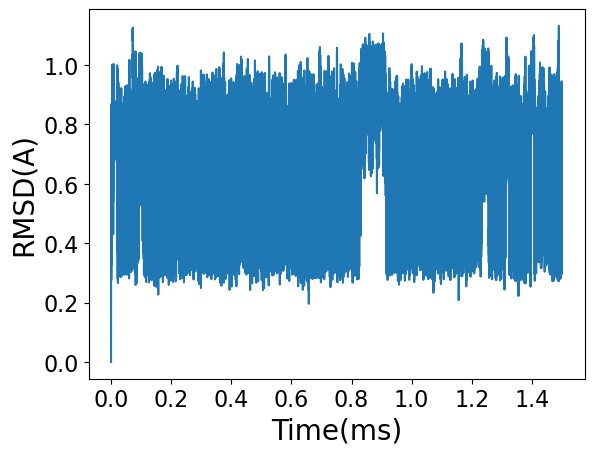

<Figure size 640x480 with 0 Axes>

In [172]:
# RMSD from first frame 
trjCA = md.load(trajectory, top=pdb)
CA=trjCA.top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()
CA_trj_sel=trj.topology.select("name CA")
rmsd = md.rmsd(trjCA, trjCA[0])
plt.plot(np.linspace(0,1.5,trjCA.n_frames),rmsd)
plt.xlabel("Time(ms)",size=20)
plt.ylabel("RMSD(A)", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()
plt.clf()

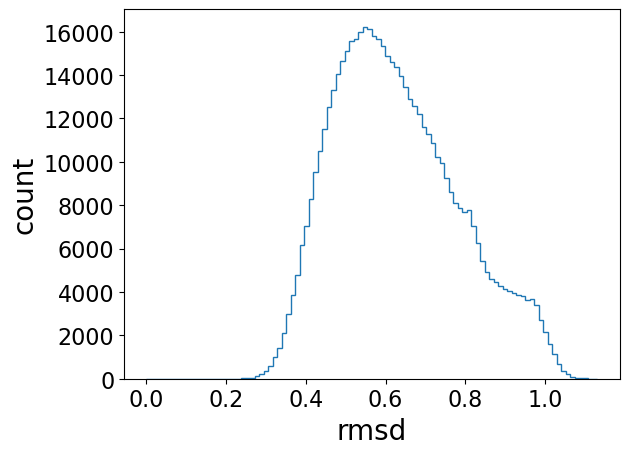

In [173]:
plt.hist(rmsd,histtype='step',bins=100)
plt.xlabel("rmsd", size=20)
plt.ylabel("count", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [174]:
trjBB = md.load(trajectory, top=pdb)
BB=trjBB.top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()
x = [res.resSeq for res in trjBB.top.residues]
dssp=md.compute_dssp(trjBB,simplified=True)

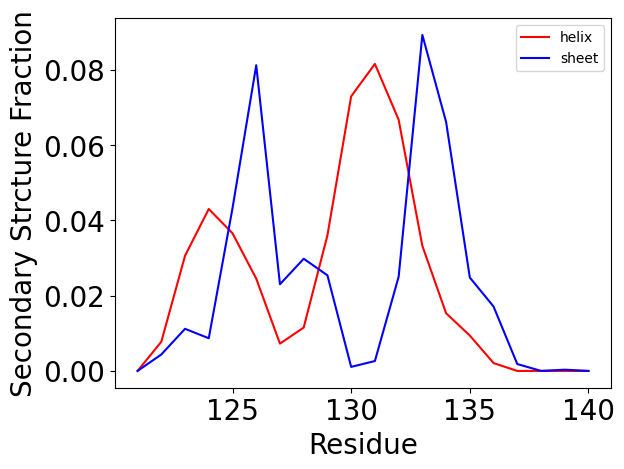

In [175]:
def dssp_convert(dssp):
    dsspH=np.copy(dssp)
    dsspE=np.copy(dssp)
    
    dsspH[dsspH=='H']=1 # helix                                                                                  
    dsspH[dsspH=='E']=0 # extended strand                                                                              
    dsspH[dsspH=='C']=0 # coil                                                                                  
    dsspH[dsspH=='NA']=0 # don't know 
    dsspH=dsspH.astype(int) # cast to int 
    TotalH=np.sum(dsspH,axis=1) 
    Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

    dsspE[dsspE=='H']=0
    dsspE[dsspE=='E']=1
    dsspE[dsspE=='C']=0
    dsspE[dsspE=='NA']=0
    dsspE=dsspE.astype(int)
    TotalE=np.sum(dsspE,axis=1) 
    Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
    return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(x,Hprop,c='r',label='helix')
plt.plot(x,Eprop,c='b',label='sheet')

plt.legend(loc="upper right")
plt.xlabel('Residue', size=20)
plt.xticks(size=16)
plt.ylabel('Secondary Strcture Fraction', size=20)
plt.yticks(size=16)
plt.tick_params(labelsize=20)
plt.show()

In [136]:
first_frame = 0
last_frame = trj.n_frames
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 294

Number of residues: 20

Number of frames: 555446

Starting frame: 0

Last frame: 555446

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA']

residue number:  [121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140]

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

